In [2]:
%load_ext autoreload
%aimport comethylation_distance, utils, methyl_mut_burden
%autoreload 1
import get_data, analysis, utils, plotting, comethylation_correlation, comethylation_distance, methyl_mut_burden

In [3]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

## Read in data

In [5]:
out_dir = "./output_110422"
dependency_f_dir = "./dependency_files"
data_dir = "./data"

In [6]:
all_illumina_cpg_locs_df = pd.read_csv(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"), sep=',', dtype={'CHR': str}, low_memory=False)
# get rows of all_illumina_cpg_locs_df where 'exon' appears in UCSC_RefGene_Group
all_illumina_cpg_locs_df.dropna(subset=['UCSC_RefGene_Group'], inplace=True)
exon_cpg_locs_df = all_illumina_cpg_locs_df[all_illumina_cpg_locs_df['UCSC_RefGene_Group'].str.contains('Body')]
cpg_in_body = exon_cpg_locs_df['Name'].to_list()

In [7]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir,
    os.path.join(data_dir, "processed_methylation"),
    os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [8]:
# read in other already computed files
# from running analysis.main() 
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

## Do mutation analyses

In [ ]:
mut_in_measured_cpg_w_methyl_age_df, all_methyl_age_df_t = analysis.main(illumina_cpg_locs_df, out_dir, all_mut_df, all_methyl_df_t, all_meta_df, dataset_names_list, age_bin_size = 5)

In [ ]:
# save ct_mut_in_measured_cpg_w_methyl_df
mut_in_measured_cpg_w_methyl_age_df.to_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))

## New Dev

In [179]:
mut_scan_multi = comethylation_distance.mutationScanDistanceMulti(all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, age_bin_size = 5,max_dist = 1000)
mut_nearby_measured_df, all_metrics_df = mut_scan_multi.look_for_disturbances(min_VAF_percentile = 50)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/cellar/users/zkoch/methylation_and_mutation/comethylation_distance.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # for each mutation with nearby measured site, compare the methylation of the nearby measured sites in the mutated samples to the other samples of same age and dataset


NOTE: Not enough samples of the same age and tissue to calculate effect of mutation for 16 mutations
NOTE: Dropped 33 samples due to mutations in other samples


In [180]:
all_metrics_df.loc[:,'measured_site_dist'] = np.abs(all_metrics_df['measured_site_dist'])
all_metrics_df.loc[:,'dist_bin'] = pd.cut(all_metrics_df['measured_site_dist'], bins=5, labels=['1', '200', '400', '600', '800'])
all_metrics_df['dist_bin'] = all_metrics_df['dist_bin'].astype(int)

In [181]:
all_metrics_df

,sample,measured_site,delta_mf_mean,delta_mf_median,modified_zscore,ztest_pval,mwu_pval,mut_cpg,mutated,measured_site_dist,sig,fdr_pval,dist_bin
0,TCGA-2F-A9KQ,cg22452520,-0.087399,-0.088523,-0.775846,0.221265,0.931142,1:24121123,False,255,False,1.00000,200
1,TCGA-2F-A9KW,cg22452520,0.064764,0.063640,0.557763,0.364728,0.931142,1:24121123,False,255,False,1.00000,200
2,TCGA-4Z-AA87,cg22452520,0.043478,0.042354,0.371205,0.542864,0.931142,1:24121123,False,255,False,1.00000,200
3,TCGA-BT-A0YX,cg22452520,-0.050326,-0.051450,-0.450926,0.481230,0.931142,1:24121123,False,255,False,1.00000,200
4,TCGA-BT-A20N,cg22452520,0.102603,0.101479,0.889397,0.151014,0.931142,1:24121123,False,255,False,1.00000,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112859,TCGA-QF-A5YT,cg13822122,-0.008485,-0.008687,-0.970197,0.170048,0.047390,21:47850117,False,943,False,0.87846,800
112860,TCGA-QS-A5YR,cg13822122,-0.003434,-0.003636,-0.406082,0.578671,0.047390,21:47850117,False,943,False,0.87846,800
112861,TCGA-SJ-A6ZJ,cg13822122,0.011746,0.011544,1.289278,0.057537,0.047390,21:47850117,False,943,False,0.87846,800
112862,TCGA-AP-A1DR,cg13822122,-0.006216,-0.006418,-0.716787,0.314818,0.047390,21:47850117,True,943,False,0.87846,800


<AxesSubplot:xlabel='dist_bin', ylabel='delta_mf_mean'>

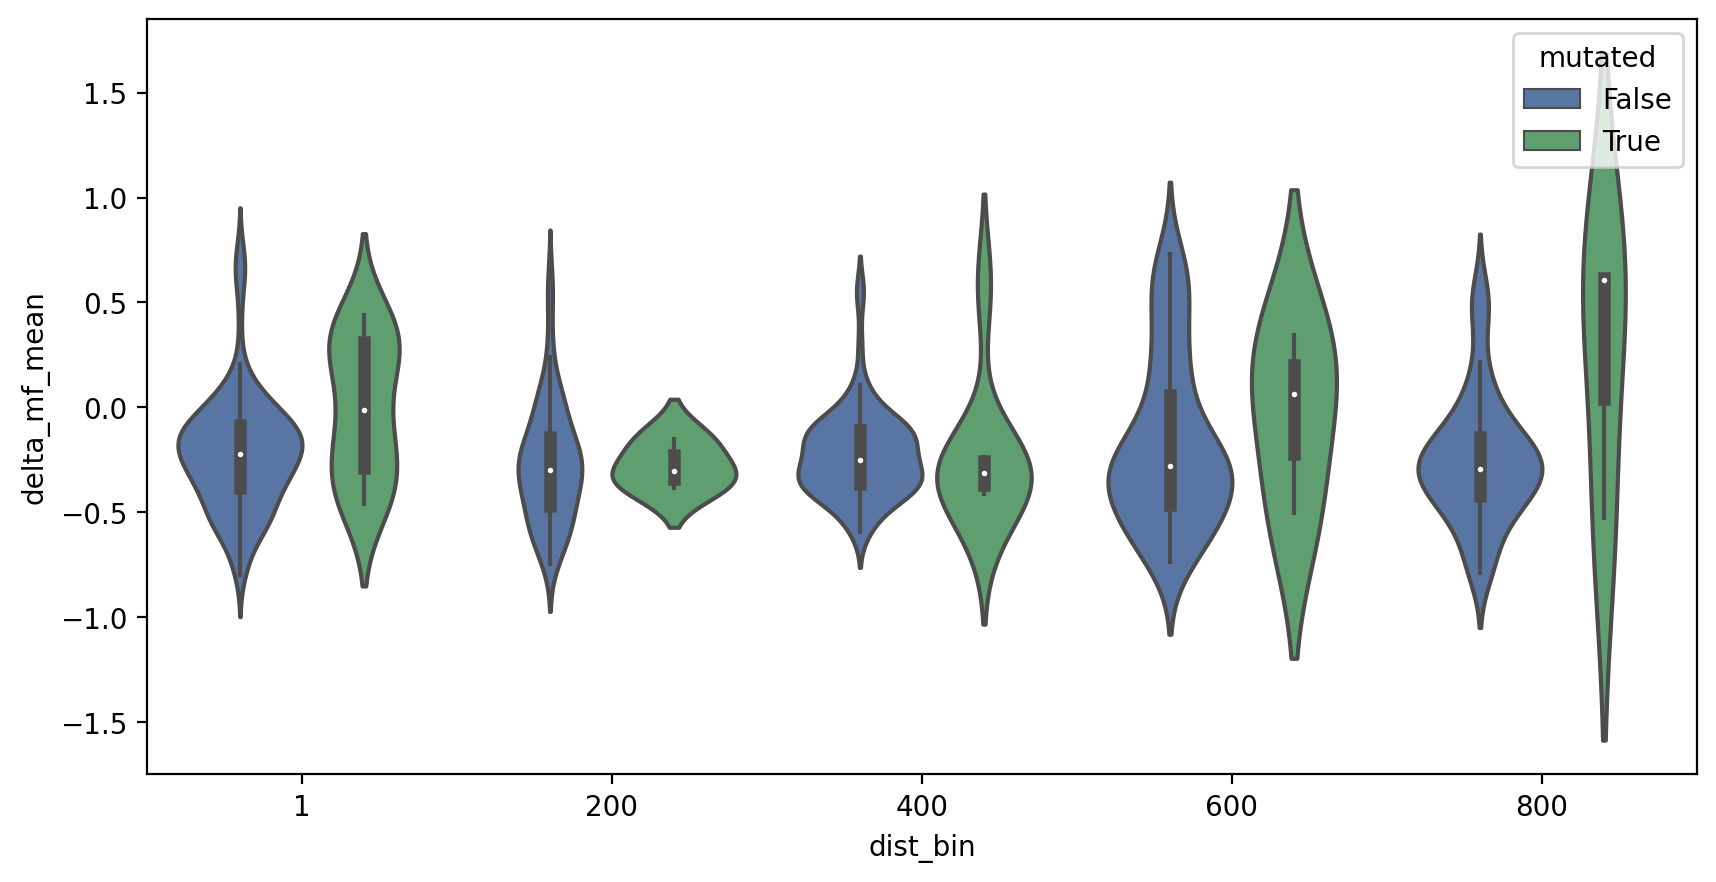

In [186]:
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(data= all_metrics_df[all_metrics_df['ztest_pval'] < .00005], x='dist_bin', y='delta_mf_mean', hue='mutated', split=False, ax=axes)

In [169]:
5/len(all_metrics_df['measured_site'].unique())

0.0029958058717795086

<AxesSubplot:xlabel='dist_bin', ylabel='modified_zscore'>

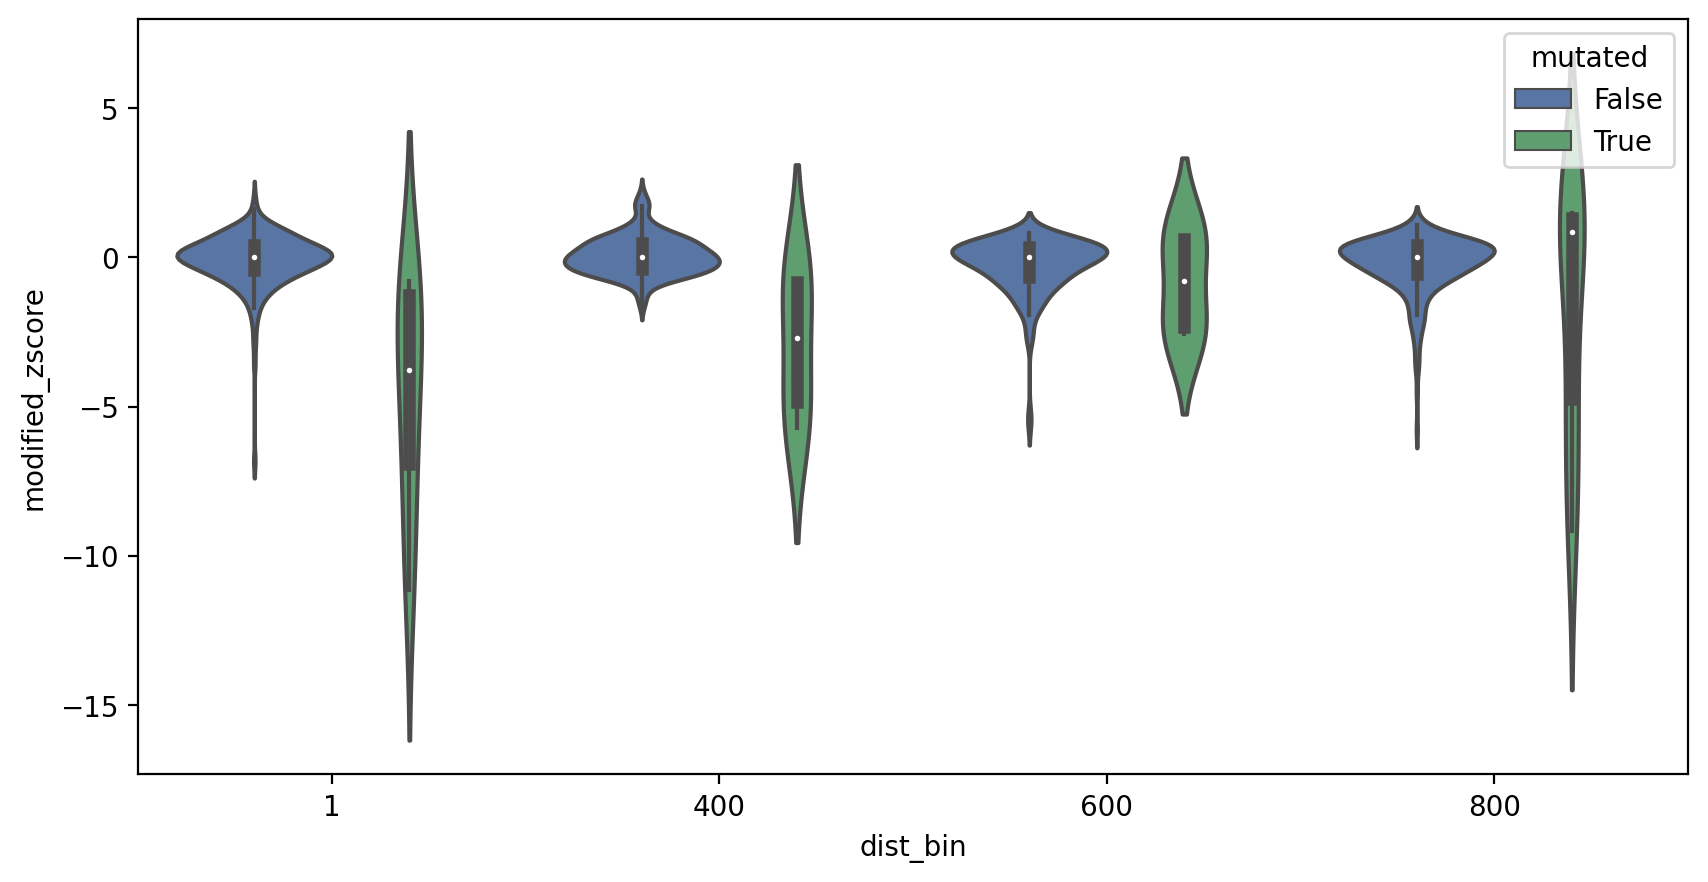

In [168]:
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(data= all_metrics_df[all_metrics_df['mwu_pval'] < 5/len(all_metrics_df['measured_site'].unique())], x='dist_bin', y='modified_zscore', hue='mutated', split=False, ax=axes)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='dist_bin', ylabel='log_modified_zscore'>

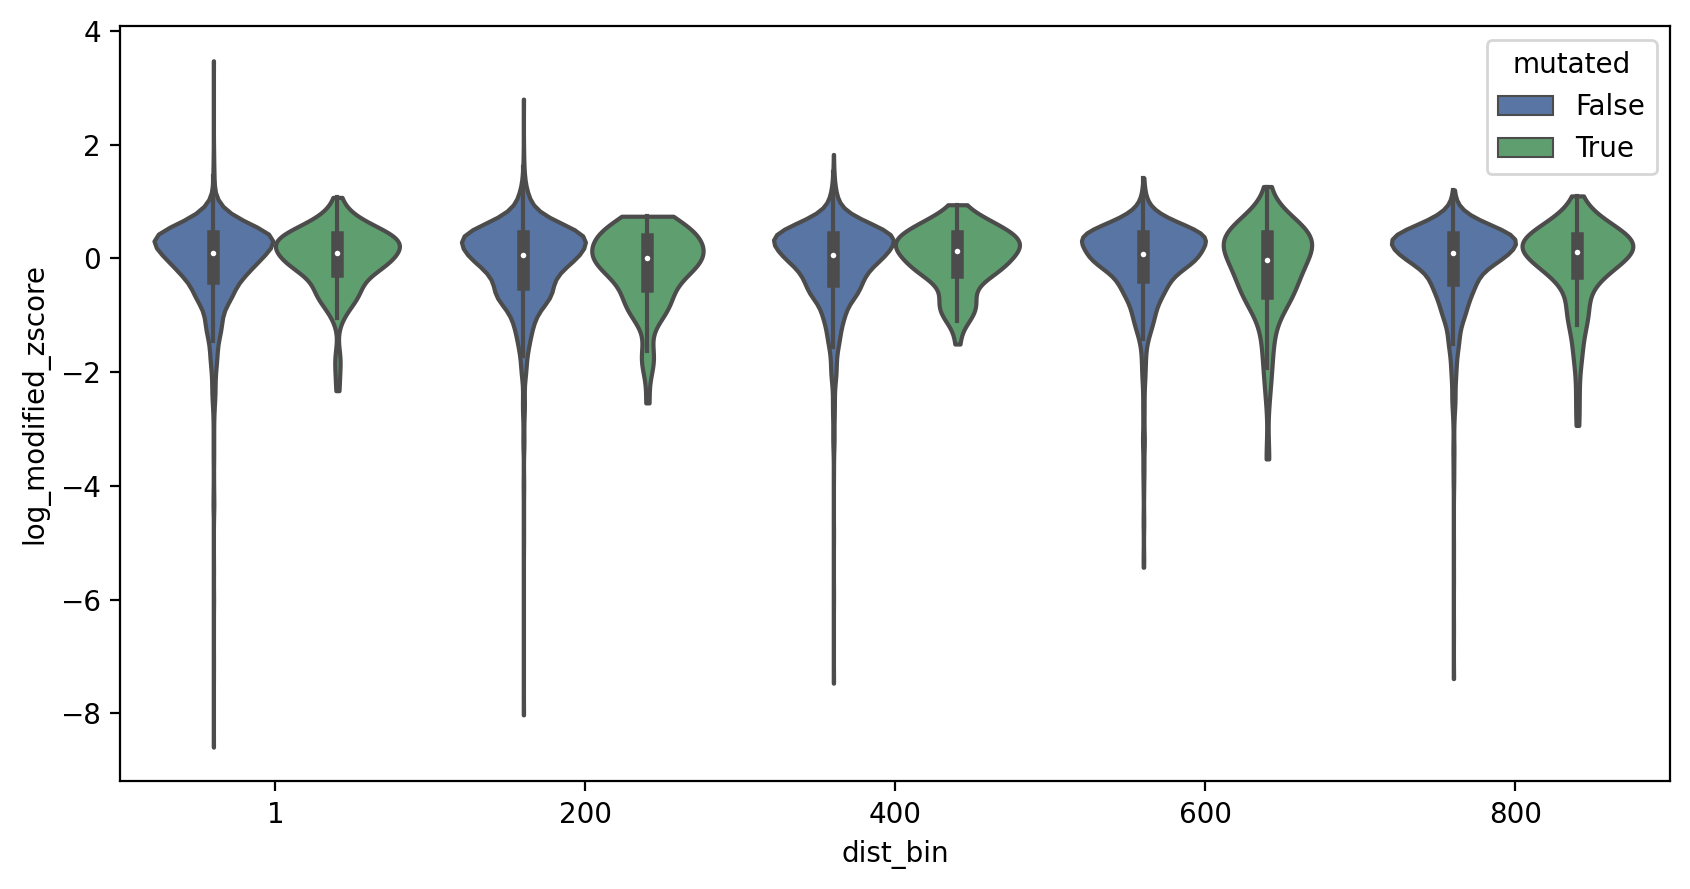

In [115]:
all_metrics_df['exp_delta_mf_median'] = all_metrics_df['delta_mf_median']**2
all_metrics_df['log_modified_zscore'] = np.log(1+all_metrics_df['modified_zscore'])
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(data= all_metrics_df, x='dist_bin', y='log_modified_zscore', hue='mutated', split=False, cut=0, ax=axes)

In [51]:
.05/len(all_metrics_df['measured_site'].unique())

2.9958058717795088e-05

In [52]:
all_metrics_df['mwu_pval'].min()

0.0005602240896358543

In [32]:
mut_nearby_measured_df

,dataset,chr,start,age_bin,samples,close_measured,close_measured_dists,mut_cpg
1428,BLCA,1,24121123,70,"[TCGA-XF-A9T0, TCGA-ZF-AA54]",[cg22452520],[255],1:24121123
38974,COAD,1,1247977,80,"[TCGA-A6-5661, TCGA-G4-6628]","[cg11847126, cg17709975, cg23689441, cg26576041]","[256, 515, 370, -48]",1:1247977
40117,COAD,1,115258747,65,"[TCGA-DM-A1D9, TCGA-G4-6315]","[cg00252422, cg07068998, cg21575283]","[479, 921, 725]",1:115258747
41224,COAD,1,237947200,70,"[TCGA-D5-6932, TCGA-G4-6299]","[cg00058296, cg03337341, cg17436298, cg19857758]","[235, 215, 145, 420]",1:237947200
63363,ESCA,1,249142293,60,"[TCGA-L5-A88V, TCGA-LN-A49U]","[cg00358451, cg07591937, cg08516035, cg18190547]","[-374, 212, 502, -229]",1:249142293
...,...,...,...,...,...,...,...,...
185661,SKCM,21,31869219,50,"[TCGA-EE-A2GB, TCGA-EE-A2M5]","[cg06515562, cg19509743]","[272, 212]",21:31869219
186293,SKCM,21,46000140,60,"[TCGA-D3-A5GS, TCGA-ER-A193]",[cg00707688],[-569],21:46000140
309695,UCEC,21,43547164,55,"[TCGA-AJ-A3OJ, TCGA-FI-A2D0]","[cg00349542, cg00969162, cg16624482]","[-671, 759, 962]",21:43547164
310076,UCEC,21,47703666,55,"[TCGA-AJ-A3EK, TCGA-FI-A2D5]",[cg14211055],[585],21:47703666


## Distance comethylation disturbance

In [9]:
mut_nearby_measured_df = pd.read_parquet(os.path.join(out_dir, "mut_nearby_measured_df_maxDist25kb_top10percVAF_all.parquet"))
nearby_diffs_df = pd.read_parquet(os.path.join(out_dir, "distance_based_diffs_df_maxDist25kb_top10percVAF_all.parquet"))

In [ ]:
mut_nearby_measured_df = pd.read_parquet(os.path.join(out_dir, "mut_nearby_measured_df_maxDist2.5kb_top25percVAF_all.parquet"))
nearby_diffs_df = pd.read_parquet(os.path.join(out_dir, "distance_based_diffs_df_maxDist2.5kb_top25percVAF_all.parquet"))
# swithc pval correction
nearby_diffs_df = nearby_diffs_df.drop(['sig', 'fdr_pval'], axis=1)
nearby_diffs_df = utils.fdr_correct_split(nearby_diffs_df, 'ztest_pval', split_col = 'mutated')
nearby_diffs_df.reset_index(inplace=True, drop=True)

In [ ]:
# run with max_dist = 500, top 25% of DNA_vaf, 
mut_scan_distance = comethylation_distance.mutationScanDistance(all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, age_bin_size = 5, max_dist = 100)
mut_nearby_measured_df, all_metrics_df = mut_scan_distance.look_for_disturbances(min_VAF_percentile = 95)

#### Heatmaps

In [ ]:
num_sig_effected = nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['sig']==True]['mut_cpg'].value_counts()
mean_delta_mf = nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['sig']==True].groupby('mut_cpg')['delta_mf'].min()
combined = pd.concat([num_sig_effected, mean_delta_mf], axis=1)


In [ ]:
combined.sort_values(by=['mut_cpg', 'delta_mf'], ascending=[False, True]).head(20)

In [ ]:
# in all 500bp top 25% set
# TCGA-BR-8487_6:31600180: 6 effected decreasing

# TCGA-CM-5861_10:81839044 increasing
# TCGA-YC-A89H_6:26234945 increasing 

In [ ]:
# in all 2500bp top 10% set
# TCGA-AZ-6598_20:2637818: no measure mutation, 13 effected decreasing
# TCGA-W3-AA1R_1:161049655: measured, 5 affected decreasing
# TCGA-DH-5140_6:32713607: measured, 4 affected decreasing

# TCGA-AX-A2HC_1:228645377: no measured mutation, 13 affected increaisng
# TCGA-2W-A8YY_2:171570371: no measured mutation, 10ish affected increasing

In [76]:
nearby_diffs_w_illum_df[(nearby_diffs_w_illum_df['sig'] == True) & (nearby_diffs_w_illum_df['mutated'] == False)]# & (nearby_diffs_w_illum_df['delta_mf'] < .1) & (nearby_diffs_w_illum_df['delta_mf'] > -.1)]

,sample,measured_site,delta_mf,measured_site_dist,mut_cpg,mutated,ztest_pval,sig,fdr_pval,chr,start,#id,Strand,dist_bin
401599,TCGA-78-7155,cg13472735,-0.515563,636,TCGA-05-4384_11:1216417,False,2.698790e-04,True,4.271854e-02,11,1216417,NaN,NaN,500
401825,TCGA-44-8119,cg06609098,-0.467172,1786,TCGA-05-4405_11:61250221,False,8.383880e-12,True,2.623551e-08,11,61250221,NaN,NaN,1500
401828,TCGA-44-8119,cg15021658,-0.442731,395,TCGA-05-4405_11:61250221,False,1.789789e-07,True,1.163120e-04,11,61250221,NaN,NaN,1
401829,TCGA-44-8119,cg15527674,-0.505405,1747,TCGA-05-4405_11:61250221,False,8.814529e-07,True,4.430007e-04,11,61250221,NaN,NaN,1500
402242,TCGA-MP-A5C7,cg15021658,-0.331672,395,TCGA-05-4405_11:61250221,False,9.209694e-05,True,1.888275e-02,11,61250221,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19154889,TCGA-BT-A2LA,cg22429169,-0.363458,583,TCGA-ZF-AA4X_20:44578141,False,1.459941e-04,True,2.683177e-02,20,44578141,NaN,NaN,500
19154930,TCGA-EJ-7782,cg01601944,-0.246702,1356,TCGA-ZG-A9N3_20:46282356,False,1.055534e-04,True,2.096576e-02,20,46282356,NaN,NaN,1000
19154956,TCGA-2Y-A9GT,cg04923604,-0.441972,1315,TCGA-ZP-A9D2_20:50140194,False,7.619272e-05,True,1.631557e-02,20,50140194,NaN,NaN,1000
19154958,TCGA-2Y-A9GT,cg07618979,-0.341638,279,TCGA-ZP-A9D2_20:50140194,False,1.311529e-04,True,2.472023e-02,20,50140194,NaN,NaN,1


0 samples excluded


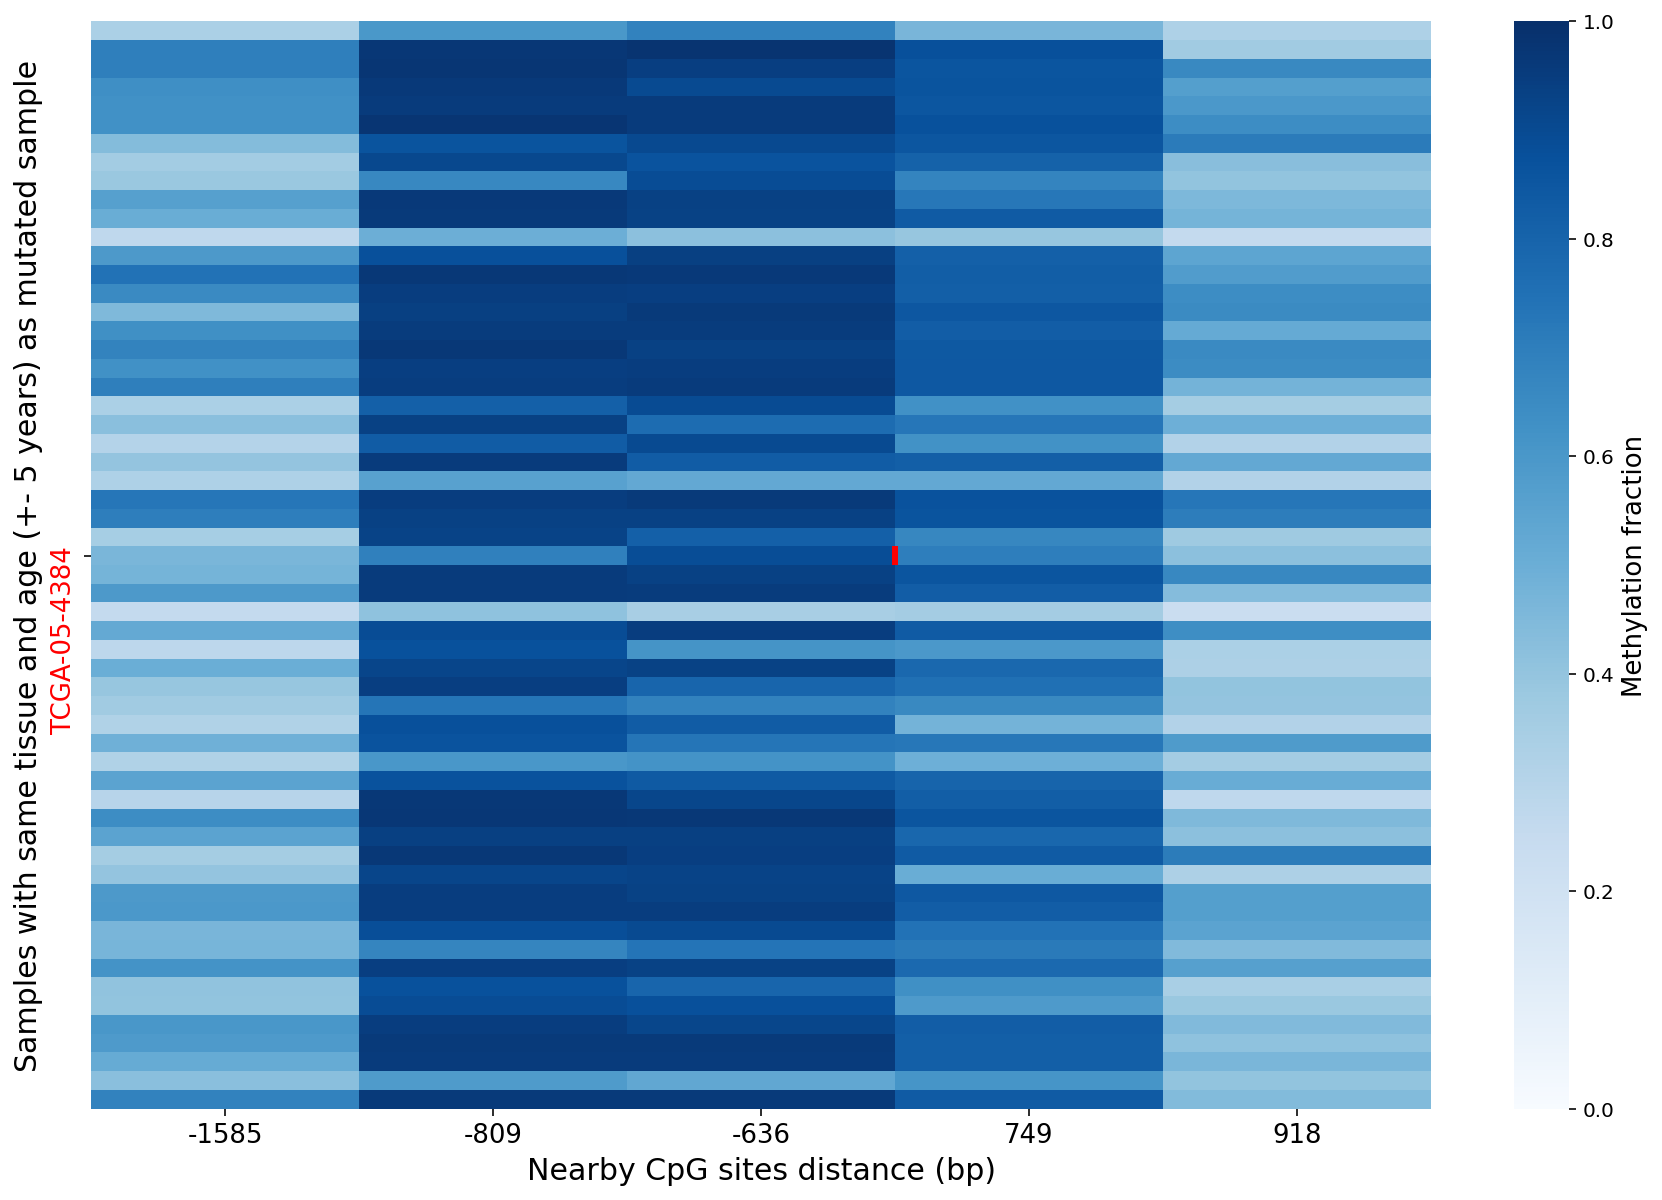

In [84]:
# TCGA-CN-A641_13:111532019 (4 site no measured mut hypermethylated decreasing methylaiton)
# TCGA-EA-A410_1:155005172, TCGA-IR-A3LA_8:92983038 (4 site w measured mut hypermethylated decreasing methylation)
# TCGA-AX-A2HC_14:31344051, TCGA-AX-A2HC_12:54394190 (6, 7 site no measured mut hypomethylated increasing methylation)
to_plot_df = mut_scan_distance.plot_heatmap('TCGA-05-4384_11:1216417', nearby_diffs_w_illum_df, mut_nearby_measured_w_illum_df)

In [138]:
pvals = []
for col in to_plot_df.columns:
    pvals.append(stats.kstest((to_plot_df.loc[:,col] - to_plot_df.loc[:,col].mean())/to_plot_df.loc[:,col].std(), stats.norm.cdf))

In [176]:
all_methyl_age_df_t.iloc[:2,:1000].append(all_methyl_age_df_t.iloc[3,:1000])

,age_at_index,dataset,cg00000165,cg00000292,cg00000363,cg00000658,cg00000721,cg00000734,cg00000769,cg00000905,...,cg00073713,cg00073794,cg00073837,cg00074086,cg00074145,cg00074184,cg00074244,cg00074348,cg00074365,cg00074415
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,58,ACC,0.903200,0.409997,0.104299,0.840895,0.938107,0.044312,0.029037,0.047910,...,0.952636,0.958029,0.418966,0.045153,0.951643,0.051310,0.055991,0.693252,0.747836,0.874758
TCGA-OR-A5J2,44,ACC,0.818523,0.552000,0.080718,0.793005,0.929483,0.056655,0.023192,0.065747,...,0.885865,0.897358,0.051493,0.038000,0.251276,0.027370,0.025250,0.150903,0.586427,0.790253
TCGA-OR-A5J4,23,ACC,0.856304,0.847317,0.714096,0.855183,0.944490,0.057167,0.026723,0.059715,...,0.941405,0.969545,0.774780,0.459734,0.039099,0.043639,0.051925,0.132955,0.711322,0.703438


In [177]:
df = pd.DataFrame(columns=all_methyl_age_df_t.columns[:1000], index=all_methyl_age_df_t.iloc[:2,:1000].index.to_list() + [all_methyl_age_df_t.iloc[3,:1000].name] )
df.iloc[:-1,:] = all_methyl_age_df_t.iloc[:2,:1000]
df.iloc[-1,:] = all_methyl_age_df_t.iloc[3,:1000]

In [175]:
df

,age_at_index,dataset,cg00000165,cg00000292,cg00000363,cg00000658,cg00000721,cg00000734,cg00000769,cg00000905,...,cg00073713,cg00073794,cg00073837,cg00074086,cg00074145,cg00074184,cg00074244,cg00074348,cg00074365,cg00074415
TCGA-OR-A5J1,58,ACC,0.9032,0.409997,0.104299,0.840895,0.938107,0.044312,0.029037,0.04791,...,0.952636,0.958029,0.418966,0.045153,0.951643,0.05131,0.055991,0.693252,0.747836,0.874758
TCGA-OR-A5J2,44,ACC,0.818523,0.552,0.080718,0.793005,0.929483,0.056655,0.023192,0.065747,...,0.885865,0.897358,0.051493,0.038,0.251276,0.02737,0.02525,0.150903,0.586427,0.790253
TCGA-OR-A5J4,23,ACC,0.856304,0.847317,0.714096,0.855183,0.94449,0.057167,0.026723,0.059715,...,0.941405,0.969545,0.77478,0.459734,0.039099,0.043639,0.051925,0.132955,0.711322,0.703438


<AxesSubplot:>

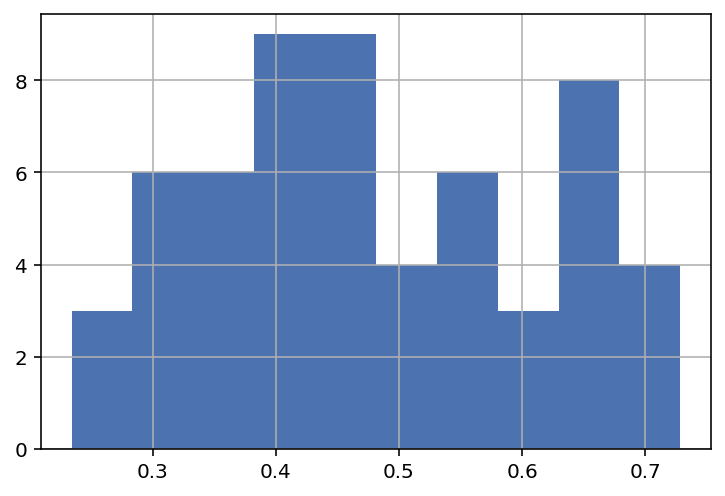

In [144]:
to_plot_df.iloc[:,4].hist()

In [122]:
pvals = []
for i in range(1, 20):
    pvals.append(stats.mannwhitneyu([0], [.99]*i).pvalue)

(0.0, 0.005)

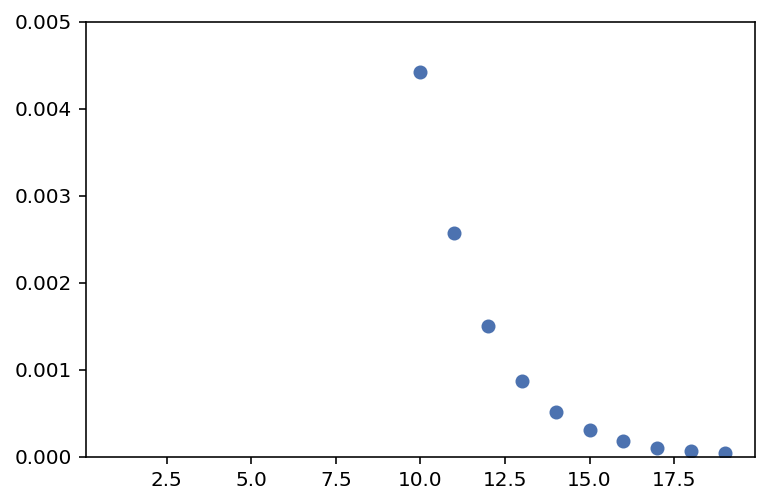

In [125]:
plt.scatter(range(1, 20), pvals)
plt.ylim(0, .005)

In [126]:
stats.mannwhitneyu(to_plot_df.loc['TCGA-78-7155','cg13472735'], to_plot_df.loc[~to_plot_df.index.isin(['TCGA-78-7155']),'cg13472735'], alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.034482758620689655)

In [ ]:
np.abs(to_plot_df.loc[:,'cg13472735'] - to_plot_df.loc[:,'cg13472735'].median()) / (stats.median_abs_deviation(to_plot_df.loc[:,'cg13472735'])*1.5)

In [109]:
# get scipy stats version information
import scipy
scipy.__version__

'1.7.1'

In [97]:
len(to_plot_df.loc[~to_plot_df.index.isin(['TCGA-78-7155']),'cg13472735'])

57

In [98]:
"""TCGA-68-7757	cg14198420"""

len(to_plot_df.loc[:,'cg13472735'].sort_values(ascending=True))

58

#### Mutation effect

In [12]:
nearby_diffs_w_illum_df = mut_scan_distance._join_with_illum(nearby_diffs_df)

In [63]:
mut_nearby_measured_w_illum_df = mut_scan_distance._join_with_illum(mut_nearby_measured_df)

In [14]:
# create 5 equal width bins of distances and assign each row to a distance bin
nearby_diffs_w_illum_df.loc[:,'measured_site_dist'] = np.abs(nearby_diffs_w_illum_df['measured_site_dist'])
nearby_diffs_w_illum_df.loc[:,'dist_bin'] = pd.cut(nearby_diffs_w_illum_df['measured_site_dist'], bins=5, labels=['1', '5000', '10000', '15000', '20000'])
nearby_diffs_w_illum_df['dist_bin'] = nearby_diffs_w_illum_df['dist_bin'].astype(int)
#nearby_diffs_w_illum_df.loc[:,'dist_bin'] = pd.cut(nearby_diffs_w_illum_df['measured_site_dist'], bins=5, labels=['1-100', '101-200', '201-300', '301-400', '401-500'])

#### Delta_mf in mutated vs nonmutated

<AxesSubplot:xlabel='delta_mf', ylabel='Density'>

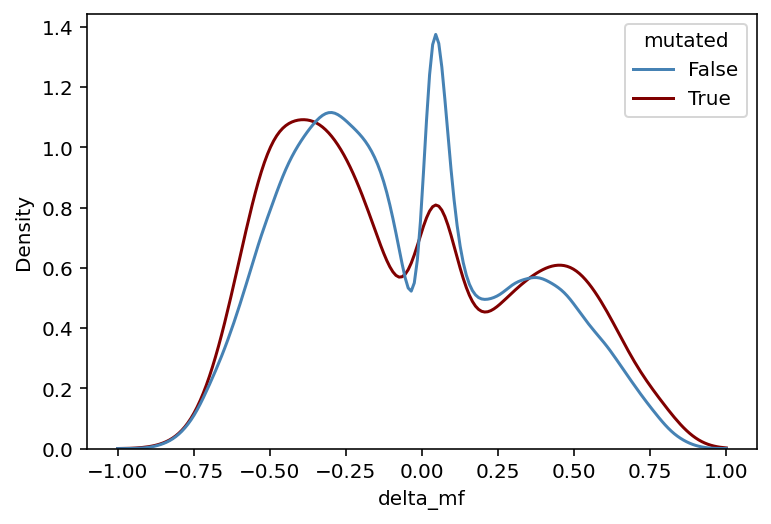

In [188]:
sns.kdeplot(data=nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['sig'] == True], x='delta_mf', hue='mutated', palette = ['steelblue', 'maroon'],common_norm=False, clip=[-1,1])

#### Frequency of any significant effect

/tmp/ipykernel_3425684/3330478042.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])


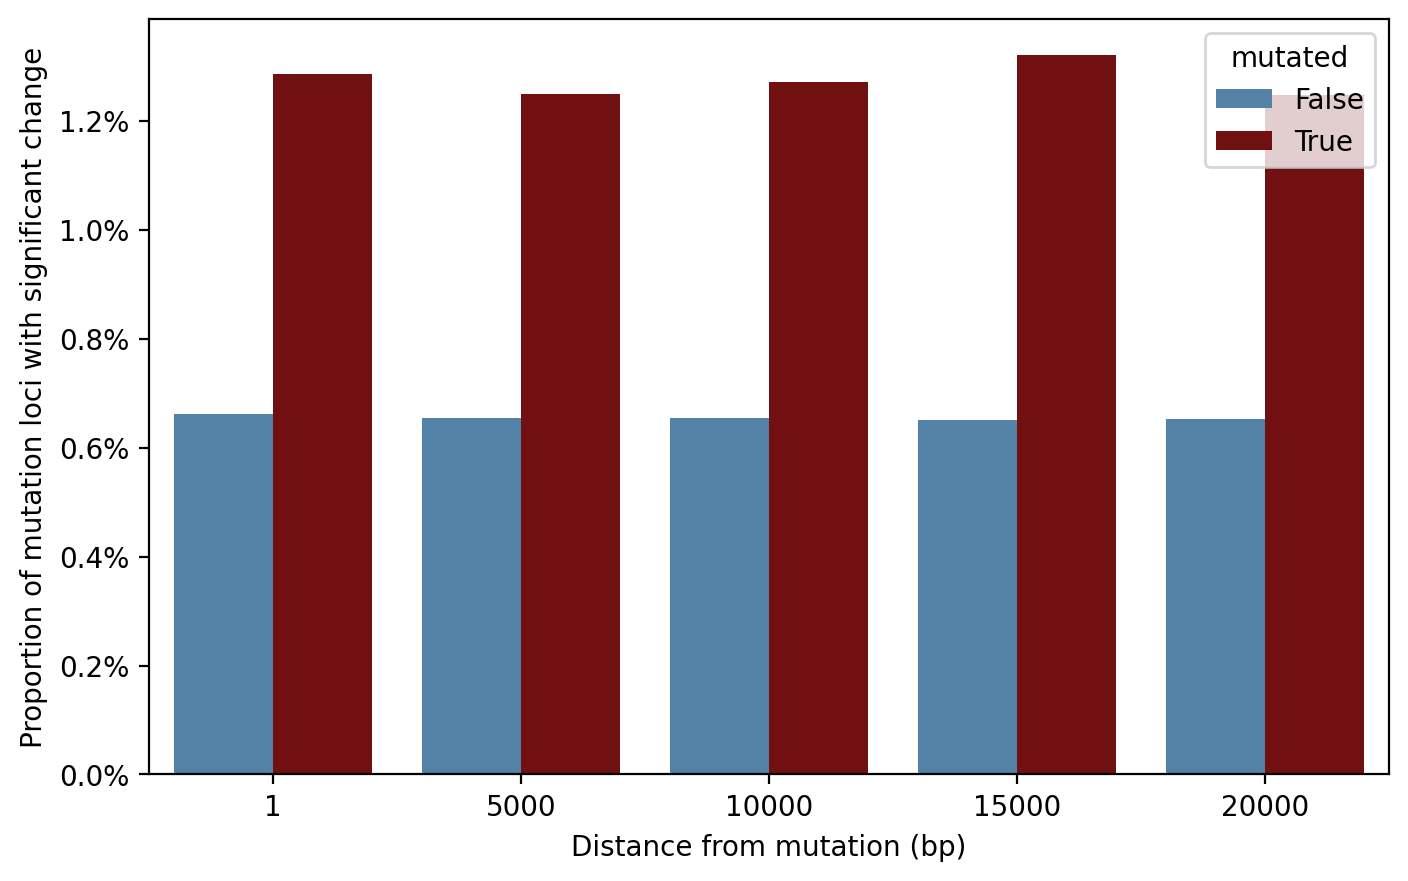

In [193]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=100)
# group by distance bin and count the proportion of sig sites for mutated and non-mutated samples
prop_sig_by_dist = nearby_diffs_w_illum_df.groupby(['mut_cpg', 'dist_bin', 'mutated', 'sample'])['sig'].mean().reset_index()
# drop rows with nan in sig column
prop_sig_by_dist.dropna(subset=['sig'], inplace=True)
# plot as a barplot
# set order of bars
#order = ['1', '500', '1000', '1500', '2000']
sns.barplot(data=prop_sig_by_dist, x='dist_bin', y='sig', hue='mutated', palette = ['steelblue', 'maroon'], ax = axes, ci=None)
# add labels
plt.xlabel('Distance from mutation (bp)')
plt.ylabel('Proportion of mutation loci with significant change')
# change y axis to percentage
_ = plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])

#### Number of affected proximal sites

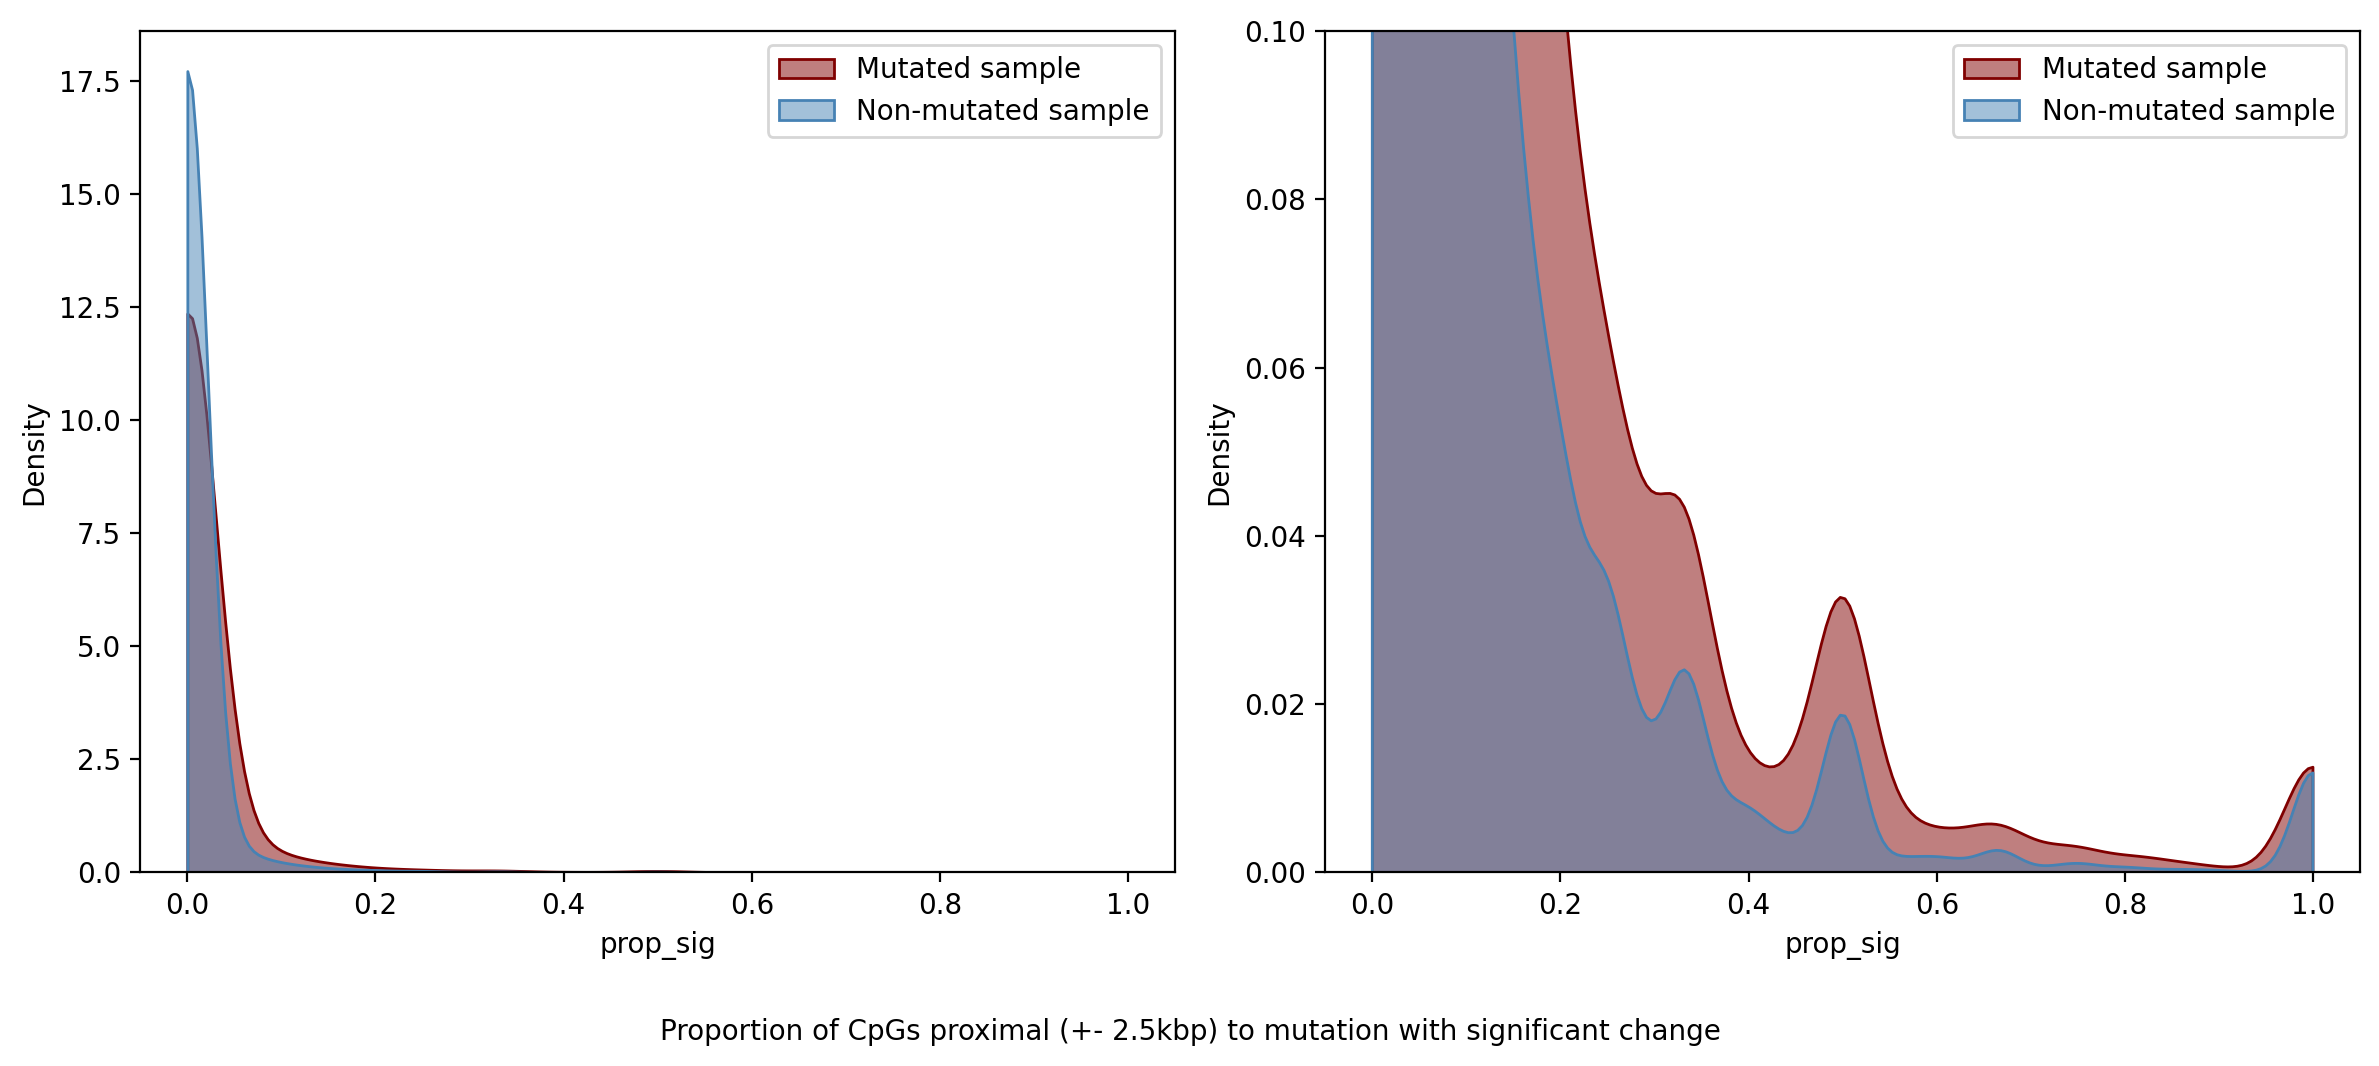

In [194]:
mut_scan_distance.prop_proximal_effected(nearby_diffs_w_illum_df)

#### Cumulative effect

In [33]:
# calculate cumulative effect = (abs?)sum of delta_mf's for each mutation in each dist bin
cumul_eff_by_dist_df = nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['sig'] == True].groupby(['mut_cpg', 'mutated', 'dist_bin', 'sample'])['delta_mf'].apply(lambda c: c.abs().sum()).reset_index()
cumul_eff_by_dist_df.columns = ['mut_cpg', 'mutated', 'dist_bin', 'sample',  'cumul_delta_mf']

In [24]:
# calculate cumulative effect = (abs?)sum of delta_mf's for each mutation in each dist bin
cumul_eff_df = nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['sig'] == True].groupby(['mut_cpg', 'mutated', 'sample'])['delta_mf'].apply(lambda c: c.abs().sum()).reset_index()
cumul_eff_df.columns = ['mut_cpg', 'mutated', 'sample',  'cumul_delta_mf']

<AxesSubplot:xlabel='dist_bin', ylabel='cumul_delta_mf'>

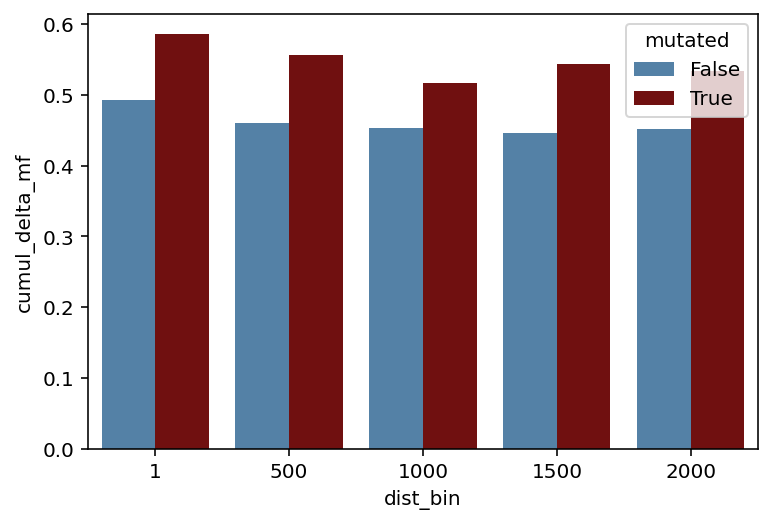

In [22]:
sns.barplot(data=cumul_eff_by_dist_df, x='dist_bin', y='cumul_delta_mf', palette=['steelblue', 'maroon'], hue='mutated', capsize=.2, ci=None)

<AxesSubplot:xlabel='dist_bin', ylabel='log_cumul_delta_mf'>

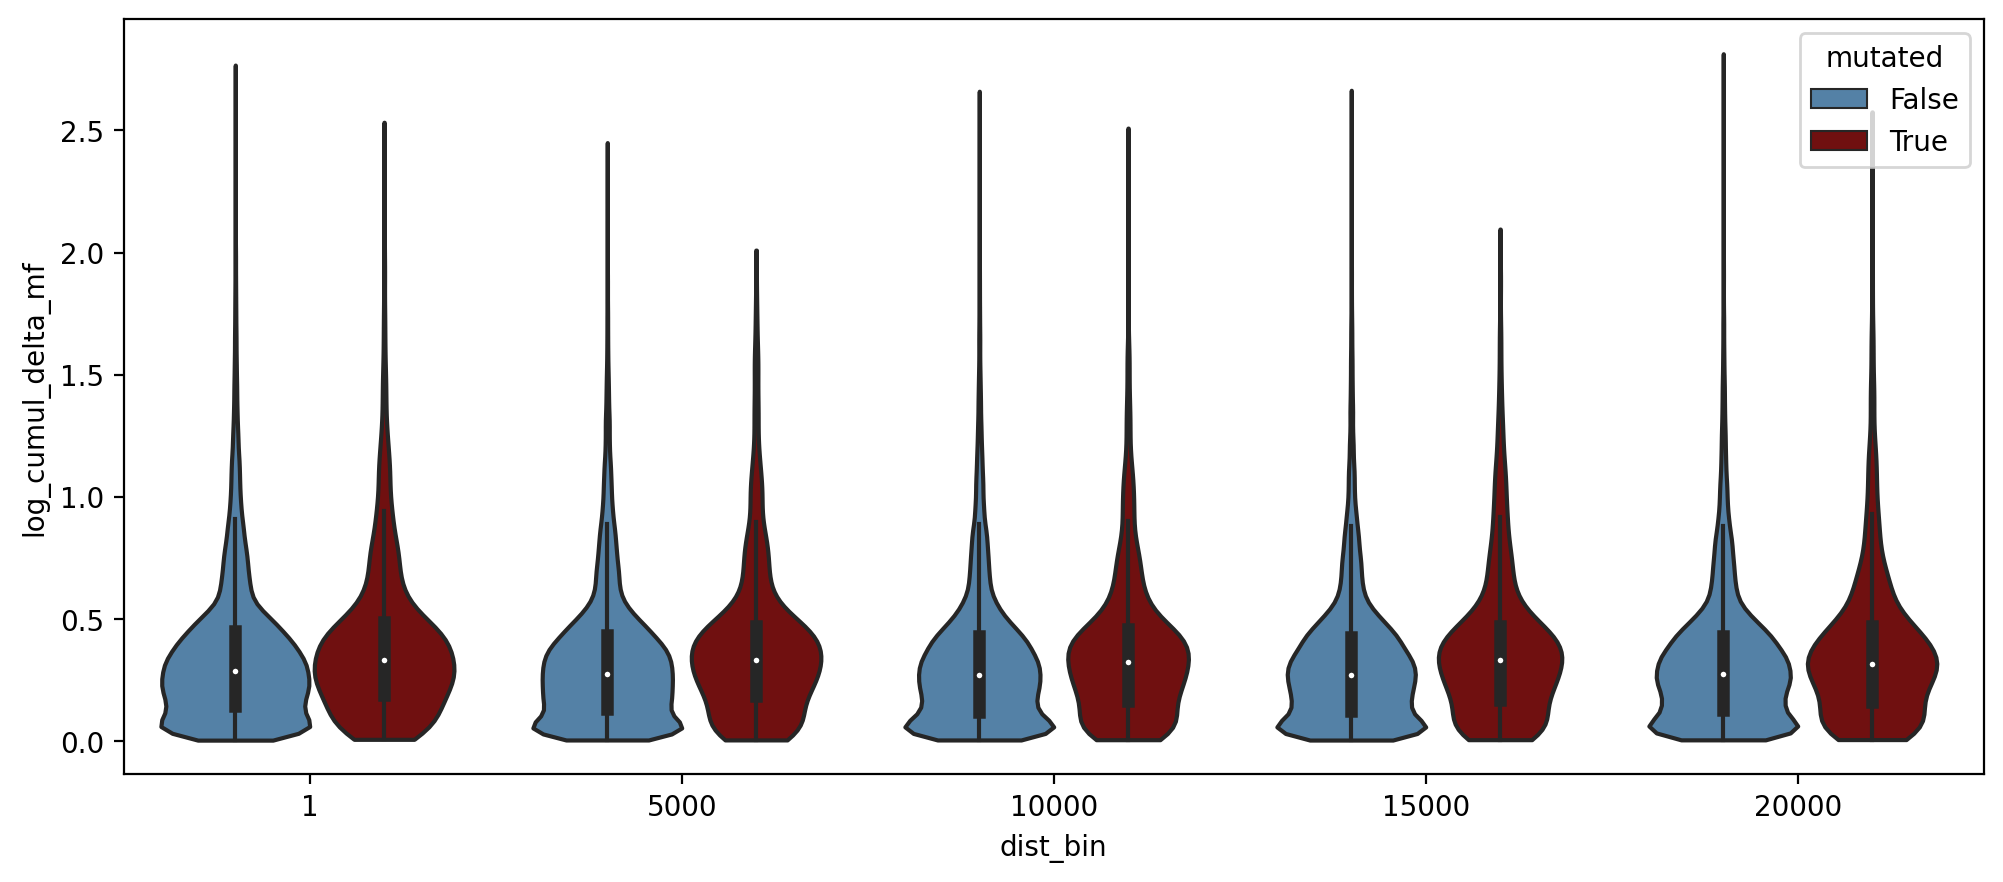

In [35]:
fig, axes = plt.subplots(figsize=(12, 5), dpi=100)
cumul_eff_by_dist_df['log_cumul_delta_mf'] = np.log(1+cumul_eff_by_dist_df['cumul_delta_mf'])
sns.violinplot(data=cumul_eff_by_dist_df, x='dist_bin', y='log_cumul_delta_mf', palette=['steelblue', 'maroon'], hue='mutated', cut=0, ax=axes)


<AxesSubplot:xlabel='mutated', ylabel='cumul_delta_mf'>

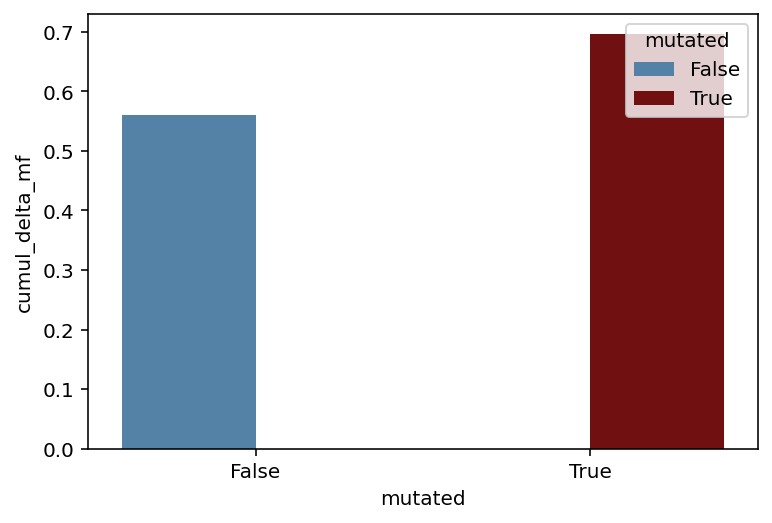

In [25]:
sns.barplot(data=cumul_eff_df, x='mutated', y='cumul_delta_mf', palette=['steelblue', 'maroon'], hue='mutated', capsize=.2, ci=None)

#### Violins

<AxesSubplot:xlabel='dist_bin', ylabel='zscore'>

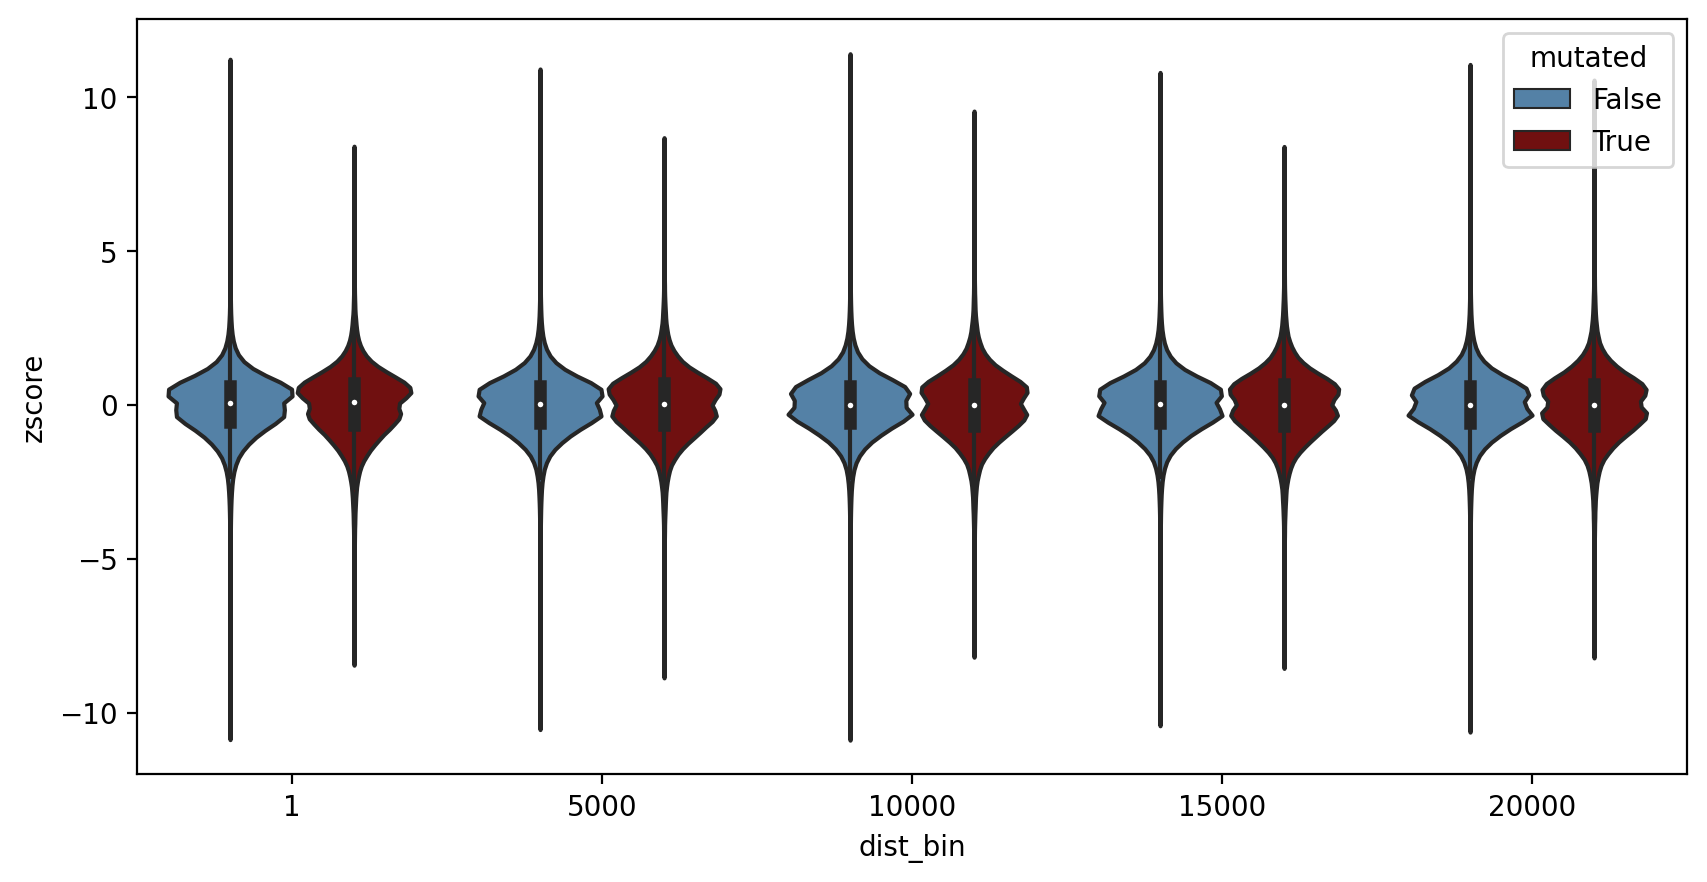

In [197]:
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(data=nearby_diffs_w_illum_df, x = 'dist_bin', y='zscore', hue='mutated', palette=['steelblue', 'maroon'], cut=0, ax=axes)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


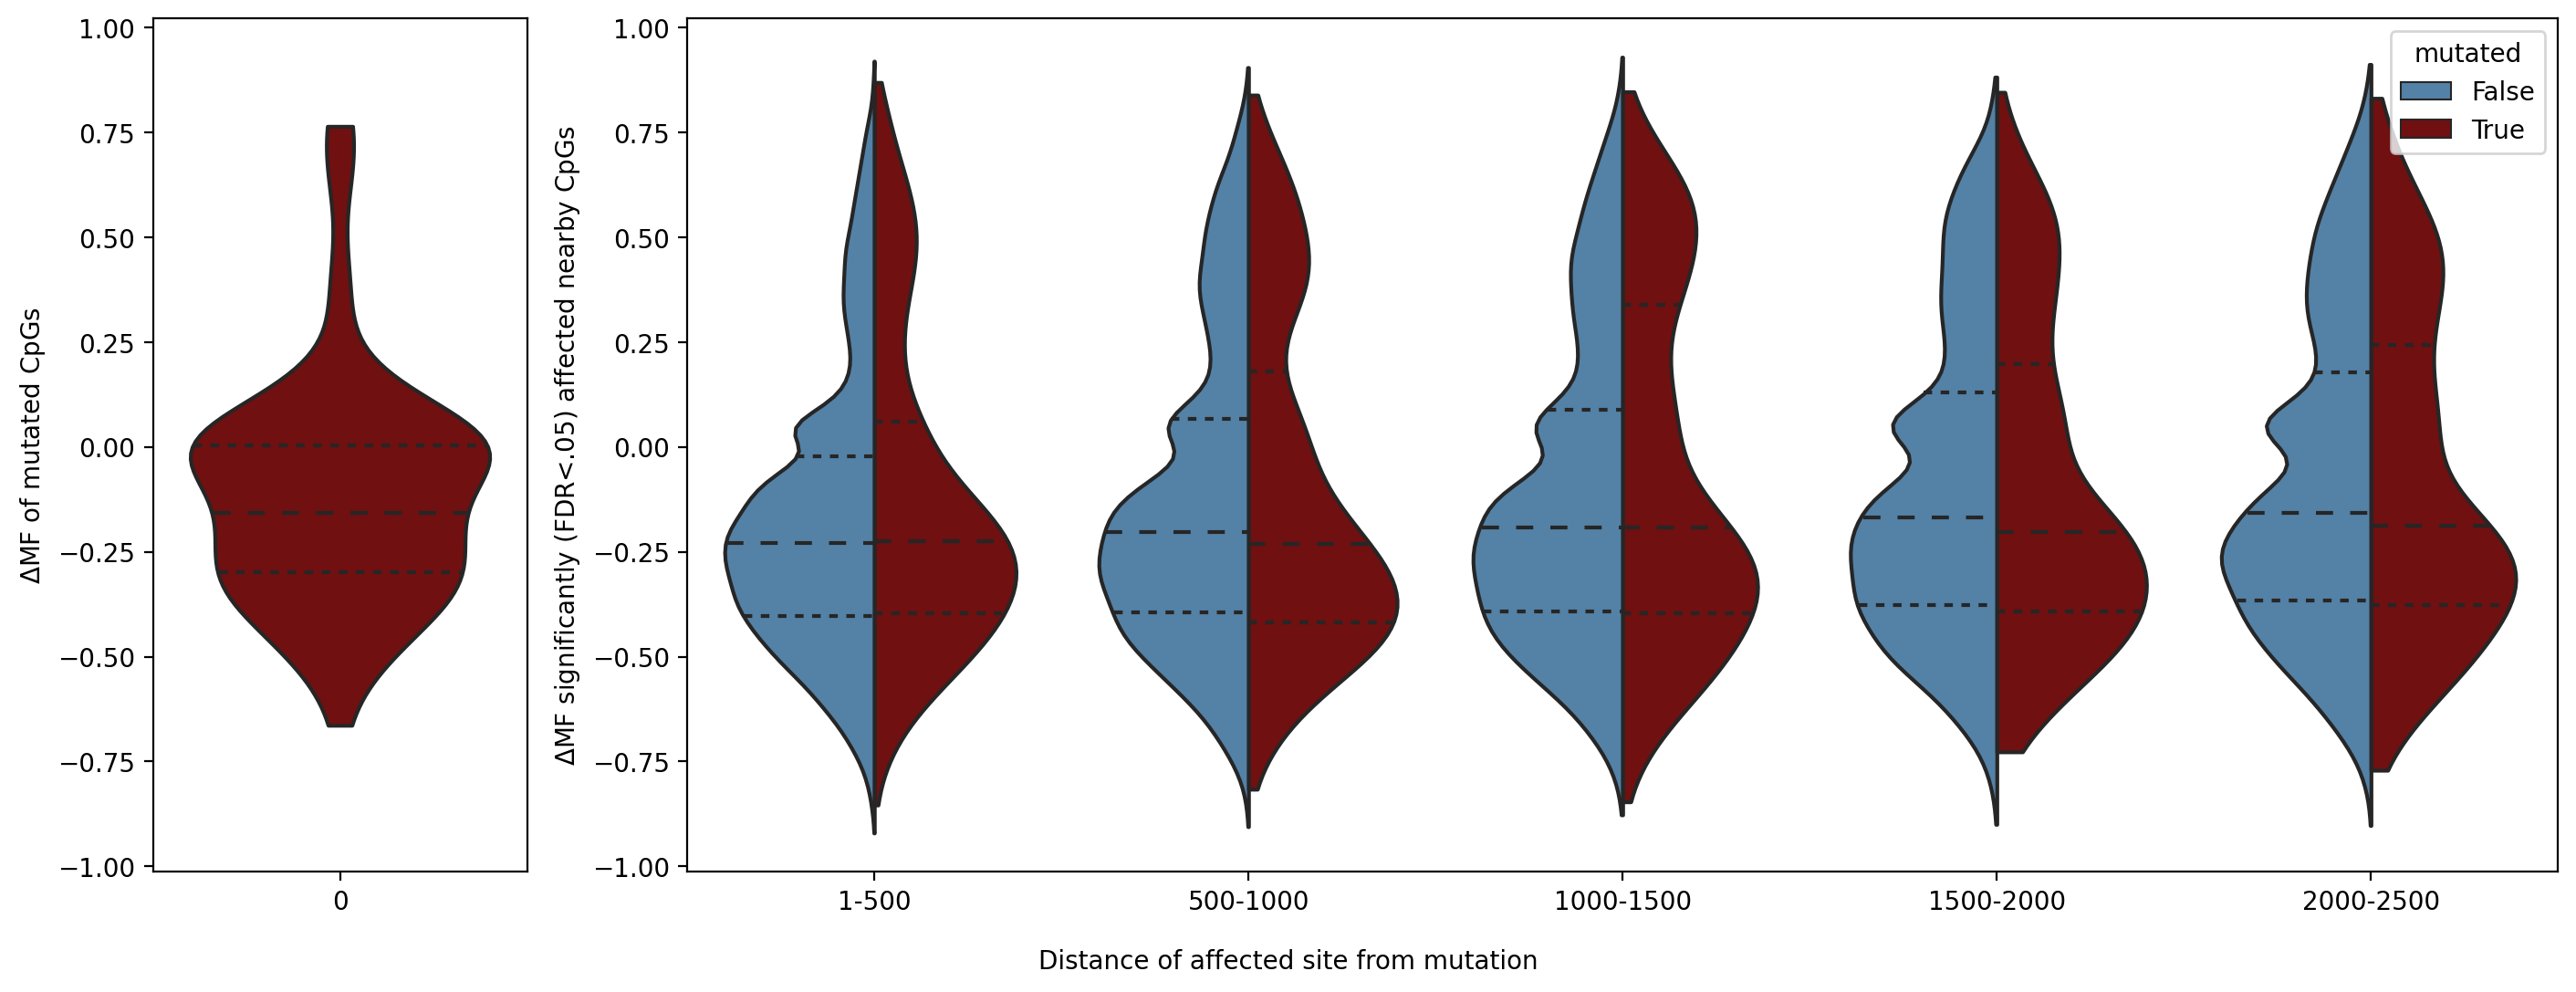

In [86]:
mut_scan_distance.effect_violin(nearby_diffs_w_illum_df, mut_in_measured_cpg_w_methyl_age_df, 'fdr_pval',  sig_thresh = .05)

In [ ]:
mut_scan_distance.mut_nearby_methyl_status_effect(nearby_diffs_df)

#### Taking mean within each distance for each sample

In [117]:
close_diffs_w_illum_df = nearby_diffs_w_illum_df[nearby_diffs_w_illum_df['measured_site_dist'] <= 500]

In [118]:
# create 5 equal width bins of distances and assign each row to a distance bin
close_diffs_w_illum_df.loc[:,'measured_site_dist'] = np.abs(close_diffs_w_illum_df.loc[:,'measured_site_dist'])
close_diffs_w_illum_df.loc[:,'dist_bin'] = pd.cut(close_diffs_w_illum_df.loc[:,'measured_site_dist'], bins=5, labels=['1', '100', '200', '300', '400'])
close_diffs_w_illum_df.loc[:, 'dist_bin'] = close_diffs_w_illum_df.loc[:,'dist_bin'].astype(int)
#nearby_diffs_w_illum_df.loc[:,'dist_bin'] = pd.cut(nearby_diffs_w_illum_df['measured_site_dist'], bins=5, labels=['1-100', '101-200', '201-300', '301-400', '401-500'])

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [119]:
close_diffs_w_illum_df

,sample,measured_site,delta_mf,delta_mf_median,ztest_pval,zscore,modified_zscore,mwu_pval,mut_cpg,mutated,measured_site_dist,sig,fdr_pval,chr,start,#id,Strand,dist_bin
14,TCGA-05-4390,cg24856673,0.000666,-0.000316,0.996379,0.004538,-0.001188,0.986301,TCGA-05-4390_12:2016649,True,485,False,0.999369,12,2016649,NaN,NaN,1
17,TCGA-05-4427,cg04001704,0.002838,0.000990,0.730710,0.344181,0.113250,0.935484,TCGA-05-4427_12:111801145,True,9,False,0.970316,12,111801145,NaN,NaN,1
18,TCGA-05-4427,cg08608727,-0.162408,-0.165964,0.120253,-1.553712,-0.902156,0.193548,TCGA-05-4427_12:111801145,True,1151,False,0.929123,12,111801145,NaN,NaN,1
20,TCGA-05-4427,cg10127221,0.020581,0.016995,0.379722,0.878409,0.500259,0.354839,TCGA-05-4427_12:111801145,True,96,False,0.970316,12,111801145,NaN,NaN,1
24,TCGA-05-4427,cg17577636,0.037681,0.025399,0.510693,0.657759,0.315830,0.516129,TCGA-05-4427_12:111801145,True,517,False,0.970316,12,111801145,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47900211,TCGA-MI-A75H,cg01579765,0.001079,0.016675,0.991383,0.010800,0.105944,0.947368,TCGA-ZS-A9CE_21:45078038,False,481,False,0.999873,21,45078038,NaN,NaN,1
47900214,TCGA-MI-A75H,cg05965188,0.011316,0.004555,0.614571,0.503560,0.258130,0.842105,TCGA-ZS-A9CE_21:45078038,False,304,False,0.999373,21,45078038,NaN,NaN,1
47900216,TCGA-MI-A75H,cg09693765,-0.068326,-0.096538,0.589213,-0.539977,-0.623465,0.526316,TCGA-ZS-A9CE_21:45078038,False,2399,False,0.999373,21,45078038,NaN,NaN,1
47900218,TCGA-MI-A75H,cg12831261,-0.023139,-0.029321,0.251450,-1.146834,-1.699938,0.315789,TCGA-ZS-A9CE_21:45078038,False,399,False,0.999373,21,45078038,NaN,NaN,1


In [120]:
mean_eff_by_dist = close_diffs_w_illum_df[close_diffs_w_illum_df['sig'] == True].groupby(['mut_cpg', 'dist_bin', 'sample'])[['delta_mf', 'delta_mf_median']].mean().reset_index()

In [121]:
# join with nearby_diffs_w_illum_df to get the methyl status of the mutation
mean_eff_by_dist_merged = mean_eff_by_dist.merge(close_diffs_w_illum_df[['mut_cpg', 'mutated', 'sample']], on=['mut_cpg', 'sample'], how='left').drop_duplicates()

In [122]:
mean_eff_by_dist_merged

,mut_cpg,dist_bin,sample,delta_mf,delta_mf_median,mutated
0,TCGA-05-4390_13:46559672,100,TCGA-69-A59K,-0.108932,-0.113099,False
3,TCGA-05-4396_16:11002979,1,TCGA-55-A490,-0.378738,-0.409259,False
10,TCGA-05-4396_16:11002979,1,TCGA-78-7167,-0.507236,-0.556968,False
17,TCGA-05-4396_16:11002979,1,TCGA-91-8499,-0.377311,-0.403768,False
24,TCGA-05-4396_16:11002979,200,TCGA-55-A490,-0.393273,-0.420995,False
...,...,...,...,...,...,...
2404670,TCGA-ZS-A9CF_6:79577582,1,TCGA-WX-AA44,0.130571,0.138569,False
2404677,TCGA-ZS-A9CG_1:200842406,1,TCGA-ED-A97K,-0.415597,-0.443767,False
2404688,TCGA-ZS-A9CG_1:200842406,1,TCGA-RC-A7SB,-0.455761,-0.478083,False
2404699,TCGA-ZS-A9CG_1:53680129,200,TCGA-DD-AAW1,-0.157517,-0.167905,False


<AxesSubplot:xlabel='delta_mf', ylabel='Density'>

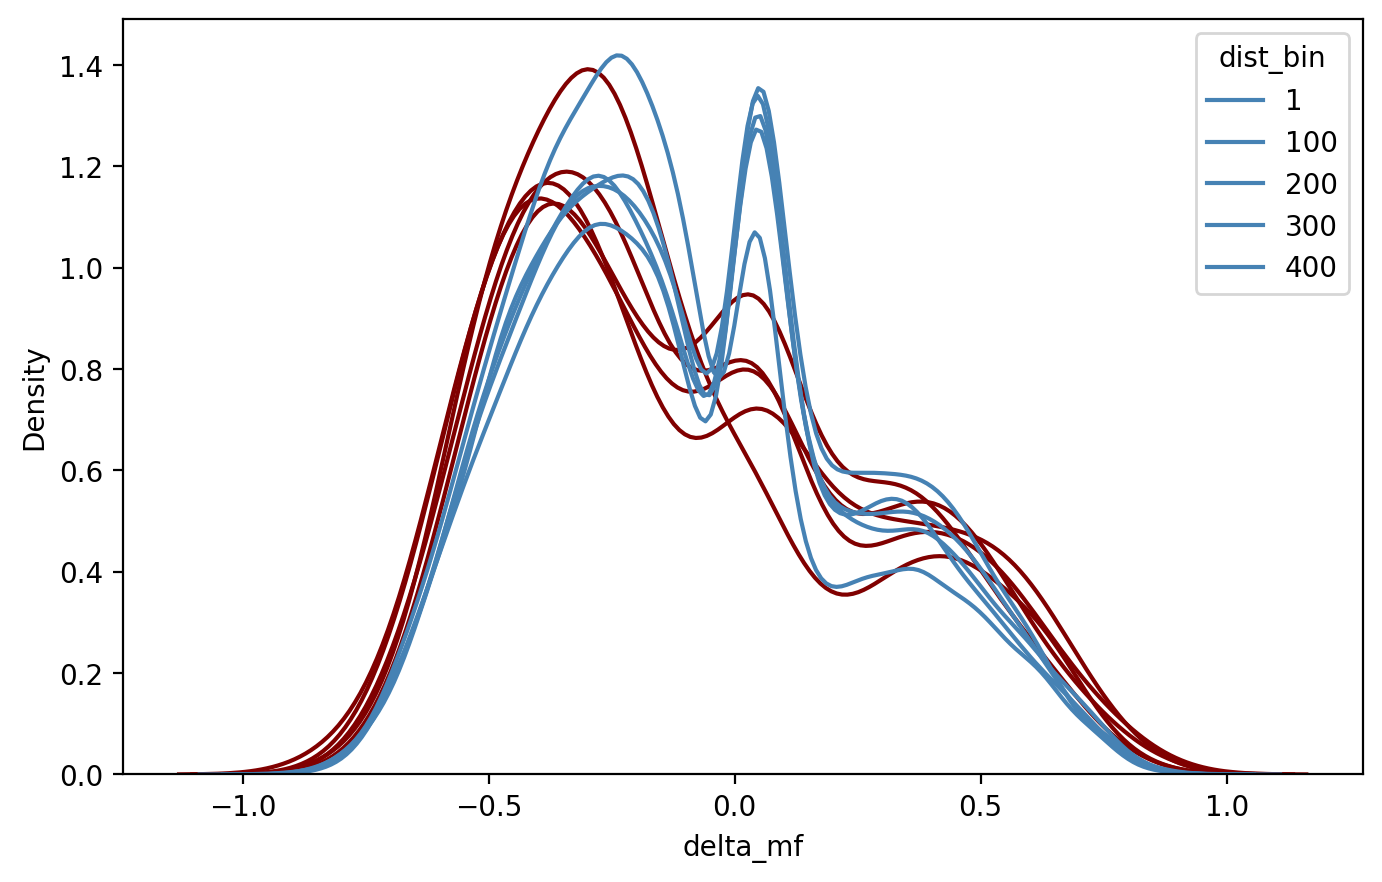

In [144]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=100)
sns.kdeplot(data=mean_eff_by_dist_merged[mean_eff_by_dist_merged['mutated'] == True], x='delta_mf', hue='dist_bin', common_norm=False, ax= axes, palette=["maroon"]*5)
sns.kdeplot(data=mean_eff_by_dist_merged[mean_eff_by_dist_merged['mutated'] == False], x='delta_mf', hue='dist_bin', common_norm=False, ax= axes, palette=["steelblue"]*5)

<AxesSubplot:xlabel='delta_mf', ylabel='Density'>

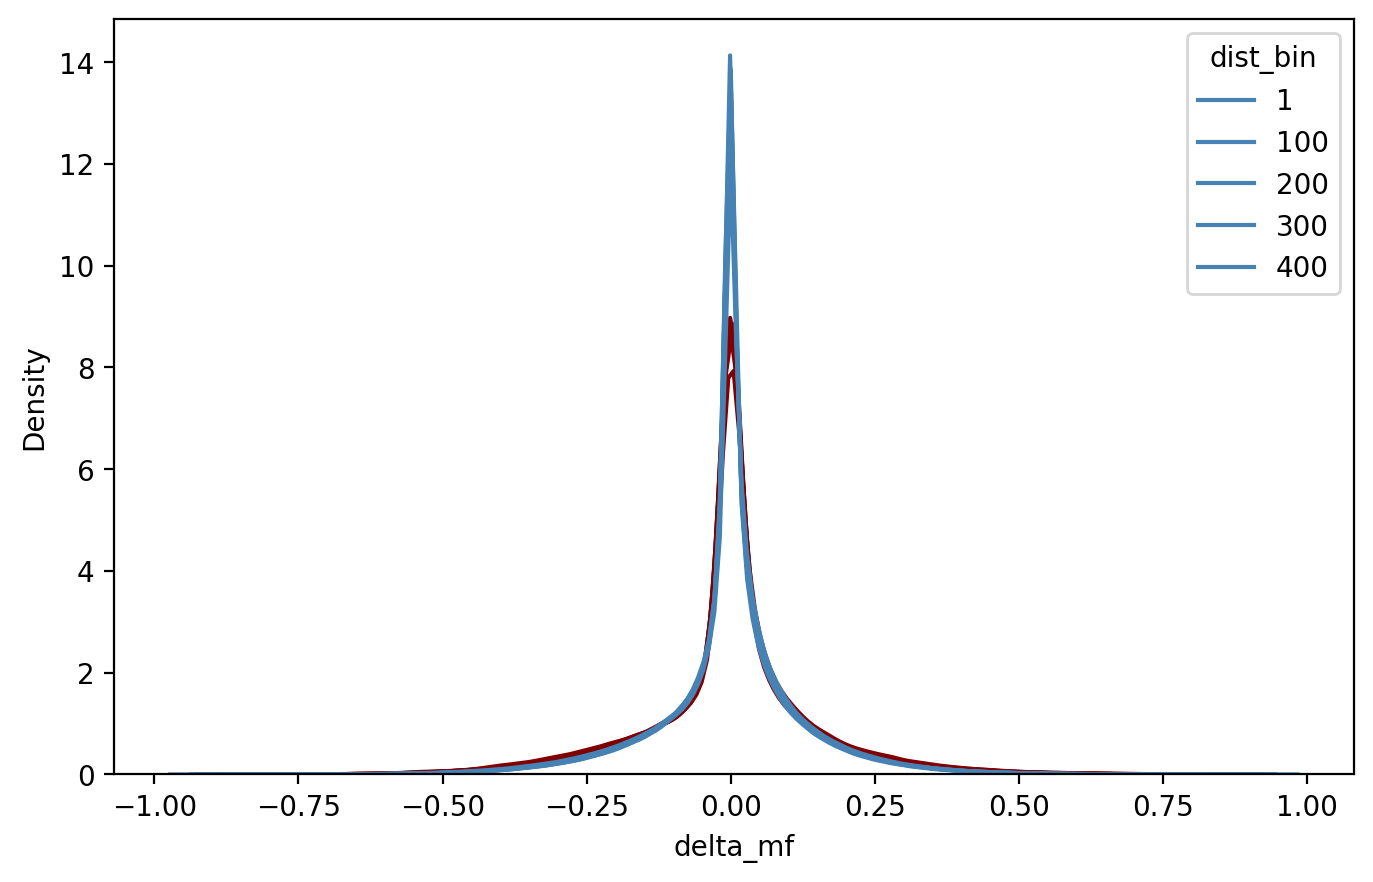

In [145]:
fig, axes = plt.subplots(figsize=(8, 5), dpi=100)
sns.kdeplot(data=close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == True], x='delta_mf', hue='dist_bin', common_norm=False, ax= axes, palette=["maroon"]*5)
sns.kdeplot(data=close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == False], x='delta_mf', hue='dist_bin', common_norm=False, ax= axes, palette=["steelblue"]*5)

#### Characteristics of significant sites

In [45]:
sig_counts_by_mut = nearby_diffs_w_illum_df.groupby(['mut_cpg', 'mutated'])['sig'].sum().reset_index()
sig_counts_by_mut.columns = ['mut_cpg', 'mutated', 'sig_count']


In [59]:
# merge with mut_nearby_measured_df on mut_cpg
sig_counts_by_mut = sig_counts_by_mut.merge(mut_nearby_measured_df, on=['mut_cpg'], how='left')

In [61]:
sig_counts_by_mut[sig_counts_by_mut['mutated'] == True].sort_values('sig_count', ascending=False).head(10)

,mut_cpg,mutated,sig_count,sample,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,close_measured,close_measured_dists
18693,TCGA-AX-A1CE_6:32798209,True,53,TCGA-AX-A1CE,6,32798209,32798209,C,T,0.55,C>T,UCEC,"[cg00340328, cg00533183, cg00720839, cg0077796...","[-1033, 12533, 2277, 13438, 13856, 19638, 1788..."
82939,TCGA-FB-AAPP_20:57484420,True,45,TCGA-FB-AAPP,20,57484420,57484420,C,T,0.96,C>T,PAAD,"[cg00267746, cg01538522, cg01748573, cg0301400...","[-20436, -20446, -20890, -20653, -18972, -2049..."
111953,TCGA-YD-A9TA_1:979610,True,41,TCGA-YD-A9TA,1,979610,979610,C,T,0.60,C>T,SKCM,"[cg00299257, cg00525597, cg01150641, cg0124493...","[-23393, -6015, -3442, 23807, 1612, 20114, -12..."
71215,TCGA-EE-A2MT_6:31594906,True,36,TCGA-EE-A2MT,6,31594906,31594906,C,T,0.74,C>T,SKCM,"[cg00141143, cg00180097, cg00408224, cg0071675...","[-7085, 6251, 4013, -6598, -4036, 5828, -7092,..."
6731,TCGA-78-7155_10:135000110,True,32,TCGA-78-7155,10,135000110,135000110,C,T,0.81,C>T,LUAD,"[cg00033834, cg00090737, cg00161878, cg0049491...","[18734, -21, 15190, 20712, -7770, -504, -6787,..."
56603,TCGA-DS-A1OC_6:33402933,True,31,TCGA-DS-A1OC,6,33402933,33402933,C,T,0.50,C>T,CESC,"[cg00039177, cg00087728, cg00256060, cg0040827...","[-17083, -17671, -17568, 19935, 19883, -23646,..."
95585,TCGA-IG-A3YB_6:31692792,True,25,TCGA-IG-A3YB,6,31692792,31692792,C,T,0.50,C>T,ESCA,"[cg00071998, cg00094901, cg00110675, cg0012437...","[15329, -22197, 5255, 5426, 2235, -1096, 11795..."
49313,TCGA-D9-A148_6:33403030,True,25,TCGA-D9-A148,6,33403030,33403030,C,T,0.56,C>T,SKCM,"[cg00039177, cg00087728, cg00256060, cg0040827...","[-17180, -17768, -17665, 19838, 19786, -23743,..."
107791,TCGA-W3-AA1V_19:54392915,True,24,TCGA-W3-AA1V,19,54392915,54392915,C,T,0.64,C>T,SKCM,"[cg00868523, cg02201774, cg02726501, cg0327371...","[-5879, -20439, 23010, 22787, -23234, -7700, 9..."
4107,TCGA-46-6026_17:77914763,True,24,TCGA-46-6026,17,77914763,77914763,C,T,0.61,C>T,LUSC,"[cg00256231, cg00257704, cg00314994, cg0108421...","[1970, -10778, 4921, 9506, -11807, 9208, -2913..."


In [70]:
# num_close is the length of close_measured
sig_counts_by_mut['num_close'] = sig_counts_by_mut['close_measured'].apply(lambda x: len(x))

<AxesSubplot:xlabel='DNA_VAF', ylabel='sig_count'>

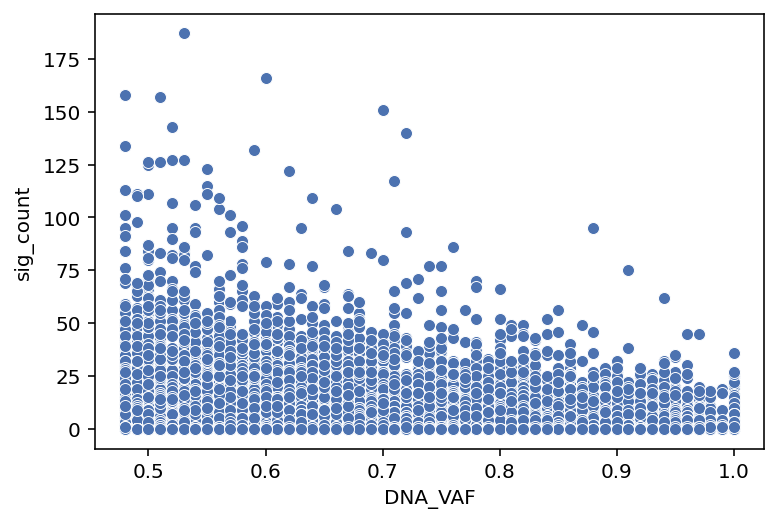

In [72]:
sns.scatterplot(data=sig_counts_by_mut, x='DNA_VAF', y = 'sig_count')

In [75]:
nearby_diffs_w_illum_df

,sample,measured_site,delta_mf,delta_mf_median,ztest_pval,zscore,modified_zscore,mwu_pval,mut_cpg,mutated,measured_site_dist,sig,fdr_pval,chr,start,#id,Strand
0,TCGA-05-4390,cg05047521,0.016515,-0.003716,0.892108,0.135637,-0.027745,0.958904,TCGA-05-4390_12:2016649,True,15846,False,0.981251,12,2016649,NaN,NaN
1,TCGA-05-4390,cg07807026,-0.053058,-0.042966,0.432884,-0.784267,-0.437394,0.383562,TCGA-05-4390_12:2016649,True,24932,False,0.970316,12,2016649,NaN,NaN
2,TCGA-05-4390,cg08621624,0.065902,0.062764,0.558625,0.584886,0.399867,0.602740,TCGA-05-4390_12:2016649,True,13574,False,0.970316,12,2016649,NaN,NaN
3,TCGA-05-4390,cg08762603,0.020784,0.041141,0.855241,0.182435,0.232398,0.821918,TCGA-05-4390_12:2016649,True,14768,False,0.976645,12,2016649,NaN,NaN
4,TCGA-05-4390,cg09110274,-0.200879,-0.238813,0.070815,-1.806664,-1.318814,0.109589,TCGA-05-4390_12:2016649,True,11605,False,0.812273,12,2016649,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47900216,TCGA-MI-A75H,cg09693765,-0.068326,-0.096538,0.589213,-0.539977,-0.623465,0.526316,TCGA-ZS-A9CE_21:45078038,False,-2399,False,0.999373,21,45078038,NaN,NaN
47900217,TCGA-MI-A75H,cg11858249,0.015535,0.017226,0.005881,2.754361,3.685444,0.105263,TCGA-ZS-A9CE_21:45078038,False,1752,False,0.368502,21,45078038,NaN,NaN
47900218,TCGA-MI-A75H,cg12831261,-0.023139,-0.029321,0.251450,-1.146834,-1.699938,0.315789,TCGA-ZS-A9CE_21:45078038,False,399,False,0.999373,21,45078038,NaN,NaN
47900219,TCGA-MI-A75H,cg13056247,0.009675,0.009948,0.577389,0.557202,0.281017,0.842105,TCGA-ZS-A9CE_21:45078038,False,322,False,0.999373,21,45078038,NaN,NaN


In [114]:
close_diffs_w_illum_df = nearby_diffs_w_illum_df[np.abs(nearby_diffs_w_illum_df['measured_site_dist']) <= 2000]
close_diffs_w_illum_df['measured_site_dist'] = np.abs(close_diffs_w_illum_df['measured_site_dist'])

/tmp/ipykernel_3518455/3310141996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diffs_w_illum_df['measured_site_dist'] = np.abs(close_diffs_w_illum_df['measured_site_dist'])


In [111]:
close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == True]

,sample,measured_site,delta_mf,delta_mf_median,ztest_pval,zscore,modified_zscore,mwu_pval,mut_cpg,mutated,measured_site_dist,sig,fdr_pval,chr,start,#id,Strand
5,TCGA-05-4390,cg11692031,0.028447,0.007587,0.658260,0.442317,0.394025,0.493151,TCGA-05-4390_12:2016649,True,1401,False,0.970316,12,2016649,NaN,NaN
6,TCGA-05-4390,cg12675583,-0.045761,-0.039891,0.667025,-0.430235,-0.219062,0.849315,TCGA-05-4390_12:2016649,True,861,False,0.970316,12,2016649,NaN,NaN
14,TCGA-05-4390,cg24856673,0.000666,-0.000316,0.996379,0.004538,-0.001188,0.986301,TCGA-05-4390_12:2016649,True,485,False,0.999369,12,2016649,NaN,NaN
17,TCGA-05-4427,cg04001704,0.002838,0.000990,0.730710,0.344181,0.113250,0.935484,TCGA-05-4427_12:111801145,True,-9,False,0.970316,12,111801145,NaN,NaN
18,TCGA-05-4427,cg08608727,-0.162408,-0.165964,0.120253,-1.553712,-0.902156,0.193548,TCGA-05-4427_12:111801145,True,-1151,False,0.929123,12,111801145,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999154,TCGA-ZS-A9CE,cg05965188,-0.034615,-0.041376,0.123491,-1.540284,-2.344764,0.315789,TCGA-ZS-A9CE_21:45078038,True,304,False,0.934004,21,45078038,NaN,NaN
999155,TCGA-ZS-A9CE,cg08871016,-0.013697,-0.025053,0.647615,-0.457079,-0.471906,0.631579,TCGA-ZS-A9CE_21:45078038,True,1194,False,0.970316,21,45078038,NaN,NaN
999157,TCGA-ZS-A9CE,cg11858249,-0.000615,0.001076,0.913241,-0.108951,0.230168,0.842105,TCGA-ZS-A9CE_21:45078038,True,1752,False,0.984444,21,45078038,NaN,NaN
999158,TCGA-ZS-A9CE,cg12831261,-0.022120,-0.028302,0.272935,-1.096330,-1.640860,0.421053,TCGA-ZS-A9CE_21:45078038,True,399,False,0.970316,21,45078038,NaN,NaN


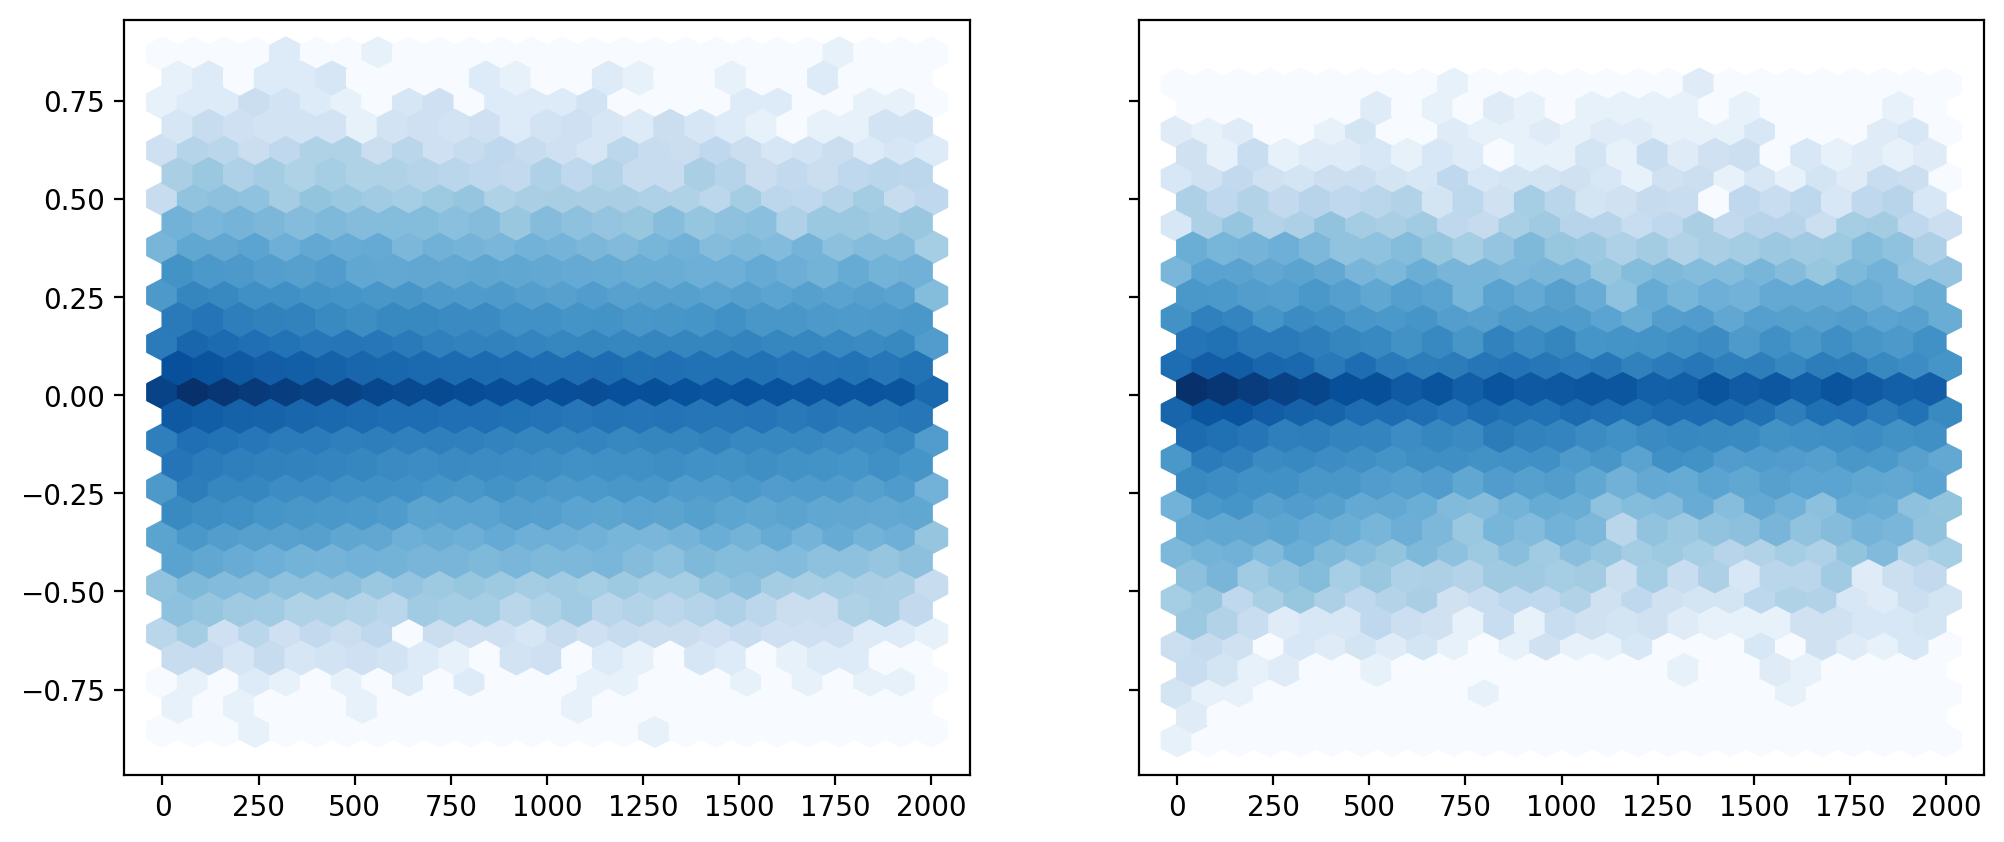

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100, sharex=True, sharey=True)
axes[0].hexbin( close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == True]['measured_site_dist'], close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == True]['delta_mf'], gridsize=25, bins='log', cmap='Blues')
axes[1].hexbin( close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == False].head(150000)['measured_site_dist'], close_diffs_w_illum_df[close_diffs_w_illum_df['mutated'] == False].head(150000)['delta_mf'], gridsize=25, bins='log', cmap='Blues')

#### Volcano plot

In [ ]:
# group by mut_cpg and count how many sig sites
sig_sites_by_mut_cpg = nearby_diffs_df[nearby_diffs_df['sig']==True].groupby('mut_cpg')['sig'].count().reset_index()

In [ ]:
len(mut_nearby_measured_df['mut_cpg'].unique())

In [ ]:
nearby_diffs_df['mut_cpg'].value_counts()

In [ ]:
sig_sites_by_mut_cpg.hist(bins=14, color='orange')
plt.xlabel('Number of CpGs significantly affected by mutation')
plt.ylabel("Count of mutations")

In [ ]:
sig_sites_by_mut_cpg = nearby_diffs_df[nearby_diffs_df['sig']==True]['mut_cpg'].value_counts()
non_sig_sites_by_mut_cpg = nearby_diffs_df[nearby_diffs_df['sig']==False]['mut_cpg'].value_counts()

In [ ]:
len(sig_sites_by_mut_cpg) / (len(sig_sites_by_mut_cpg) + len(non_sig_sites_by_mut_cpg))

In [ ]:
# create a volcano plot of delta_mf and ztest_pval
mut_scan_distance.volcano_plot(nearby_diffs_df)

## Correlation comethylation disturbance 

In [ ]:
# choose mutations to those on chr1 with large MF difference
biggest_diff_muts = mut_in_measured_cpg_w_methyl_age_df[(mut_in_measured_cpg_w_methyl_age_df['difference'] < 0)].sort_values(by='difference').iloc[:10000] # (mut_in_measured_cpg_w_methyl_age_df['#id'].isin(illumina_cpg_locs_df[illumina_cpg_locs_df['chr'] == '1']['#id'])) & 
# create a list of tuples from case_submitter_id and #id columns
mut_list = list(zip(biggest_diff_muts['case_submitter_id'], biggest_diff_muts['#id']))

In [ ]:
linked_sites_names_dfs, linked_sites_diffs_dfs, linked_sites_z_pvals_dfs = comethylation_correlation.mutation_eff_varying_linkage_perc(
    mut_list,
    all_methyl_age_df_t,
    illumina_cpg_locs_df,
    mut_in_measured_cpg_w_methyl_age_df,
    num_linked_sites = 5,
    age_bin_size= 5)

In [ ]:
utils.write_out_results_new(
    out_dir,
    'correlation_disturbance_50linked_UCEC',
    linked_sites_names_dfs,
    linked_sites_diffs_dfs,
    linked_sites_z_pvals_dfs)

In [ ]:
linked_sites_names_dfs, linked_sites_diffs_dfs, linked_sites_z_pvals_dfs = utils.read_in_result_dfs(
                                        os.path.join(out_dir, 'correlation_disturbance_5linked_UCEC'),
                                        PERCENTILES=[1])

In [ ]:
# stack linked_sites_diffs_dfs[0]
diff_and_pval_df = utils.stack_and_merge(linked_sites_diffs_dfs[0], linked_sites_z_pvals_dfs[0])
# fdr correct
diff_and_pval_df = utils.fdr_correct(diff_and_pval_df, 'pval')

In [ ]:
diff_and_pval_df.columns

In [ ]:
#UCEC
diff_and_pval_df['pval'].hist(bins=100)

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
# put x in order
diff_and_pval_df['comparison_site'] = diff_and_pval_df['comparison_site'].astype(int)
diff_and_pval_df = diff_and_pval_df.sort_values(by='comparison_site')
sns.violinplot(data=diff_and_pval_df[diff_and_pval_df['pval'] <= .05], y = 'delta_mf', x= 'comparison_site', scale='count')
sns.stripplot(data=diff_and_pval_df[diff_and_pval_df['pval'] <= .05], y = 'delta_mf', x= 'comparison_site', color='black', alpha=0.5, jitter=0.2)

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
# put x in order
diff_and_pval_df['comparison_site'] = diff_and_pval_df['comparison_site'].astype(int)
diff_and_pval_df = diff_and_pval_df.sort_values(by='comparison_site')
sns.violinplot(data=diff_and_pval_df[diff_and_pval_df['pval'] <= .05], y = 'delta_mf', x= 'comparison_site', scale='count')
sns.stripplot(data=diff_and_pval_df[diff_and_pval_df['pval'] <= .05], y = 'delta_mf', x= 'comparison_site', color='black', alpha=0.5, jitter=0.2)

In [ ]:
plotting.plot_eff_violin(biggest_diff_muts, linked_sites_z_pvals_dfs, linked_sites_diffs_dfs, sig_thresh=.05, mean = False, absolut = False)

## MMB (Methylome mutational burden)

In [39]:
mbb = methyl_mut_burden.methylomeMutationalBurden(all_mut_df, all_methyl_age_df_t, age_bin_size = 5)

In [59]:
pair_comp_df = mbb.compare_pairs(num_samples = 30, same_age = False)

Comparing pairs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

In [ ]:
pair_comp_df.to_parquet(os.path.join(out_dir, "pair_comp_all_diffAges.parquet"))
#pair_comp_corr_df.to_parquet(os.path.join(out_dir, "pair_comp_corr_spearman_20_diffAges.parquet"))

In [ ]:
mbb._plot_mf_change(num_samples=10)

### Multiple correlation

#### Same age

In [32]:
pair_comp_df = pd.read_parquet(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_101322', "pair_comp_df_500samples.parquet"))
pair_comp_corr_df = pd.read_parquet(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_101322', "pair_comp_corr_df_500samples_spearman.parquet"))

In [33]:
pair_comp_corr_df.columns = ['Absolute methylome\ndistance', 'Positive methylomes\ndistance', 'Negative methylomes\ndistance', 'Mutation count\ndifference', 'C>T mutation count\ndifference', 'Age of pair']
pair_comp_corr_df.index =  ['Absolute methylome\ndistance', 'Positive methylomes\ndistance', 'Negative methylomes\ndistance', 'Muation count\ndifference', 'C>T mutation count\ndifference', 'Age of pair']
#pair_comp_corr_df = pair_comp_corr_df.iloc[[0, 5, 3, 4], [0, 5, 3, 4]]

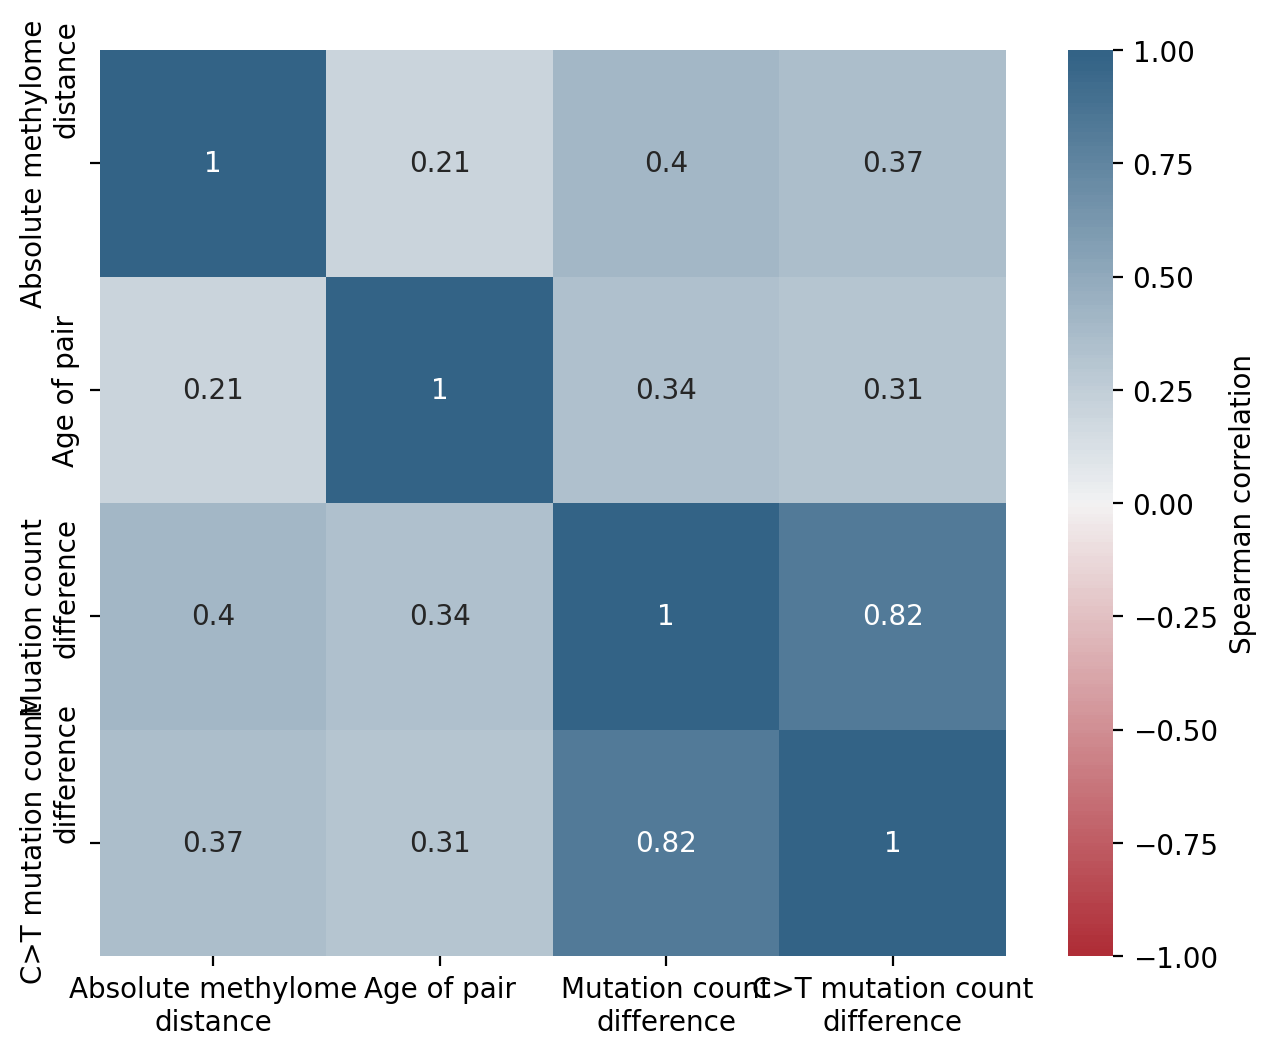

In [34]:
fig, axes = plt.subplots(figsize=(8, 6), dpi=100)
ax = sns.heatmap(
    pair_comp_corr_df.iloc[[0, 5, 3, 4], [0, 5, 3, 4]], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 240, l=40, n=200),
    square=True, ax=axes, annot=True, cbar=True
)
# name color bar
# make color bar same height as plot
ax.collections[0].colorbar.set_label("Spearman correlation")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='center'
);
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=90,
    verticalalignment='center'
);

                            OLS Regression Results                            
Dep. Variable:           abs_diff_sum   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2809.
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:12:02   Log-Likelihood:            -2.3664e+05
No. Observations:               22738   AIC:                         4.733e+05
Df Residuals:                   22736   BIC:                         4.733e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.087e+04    124.560    167.555   

Text(0.05, 0.95, '$PearsonR$ = 0.3364')

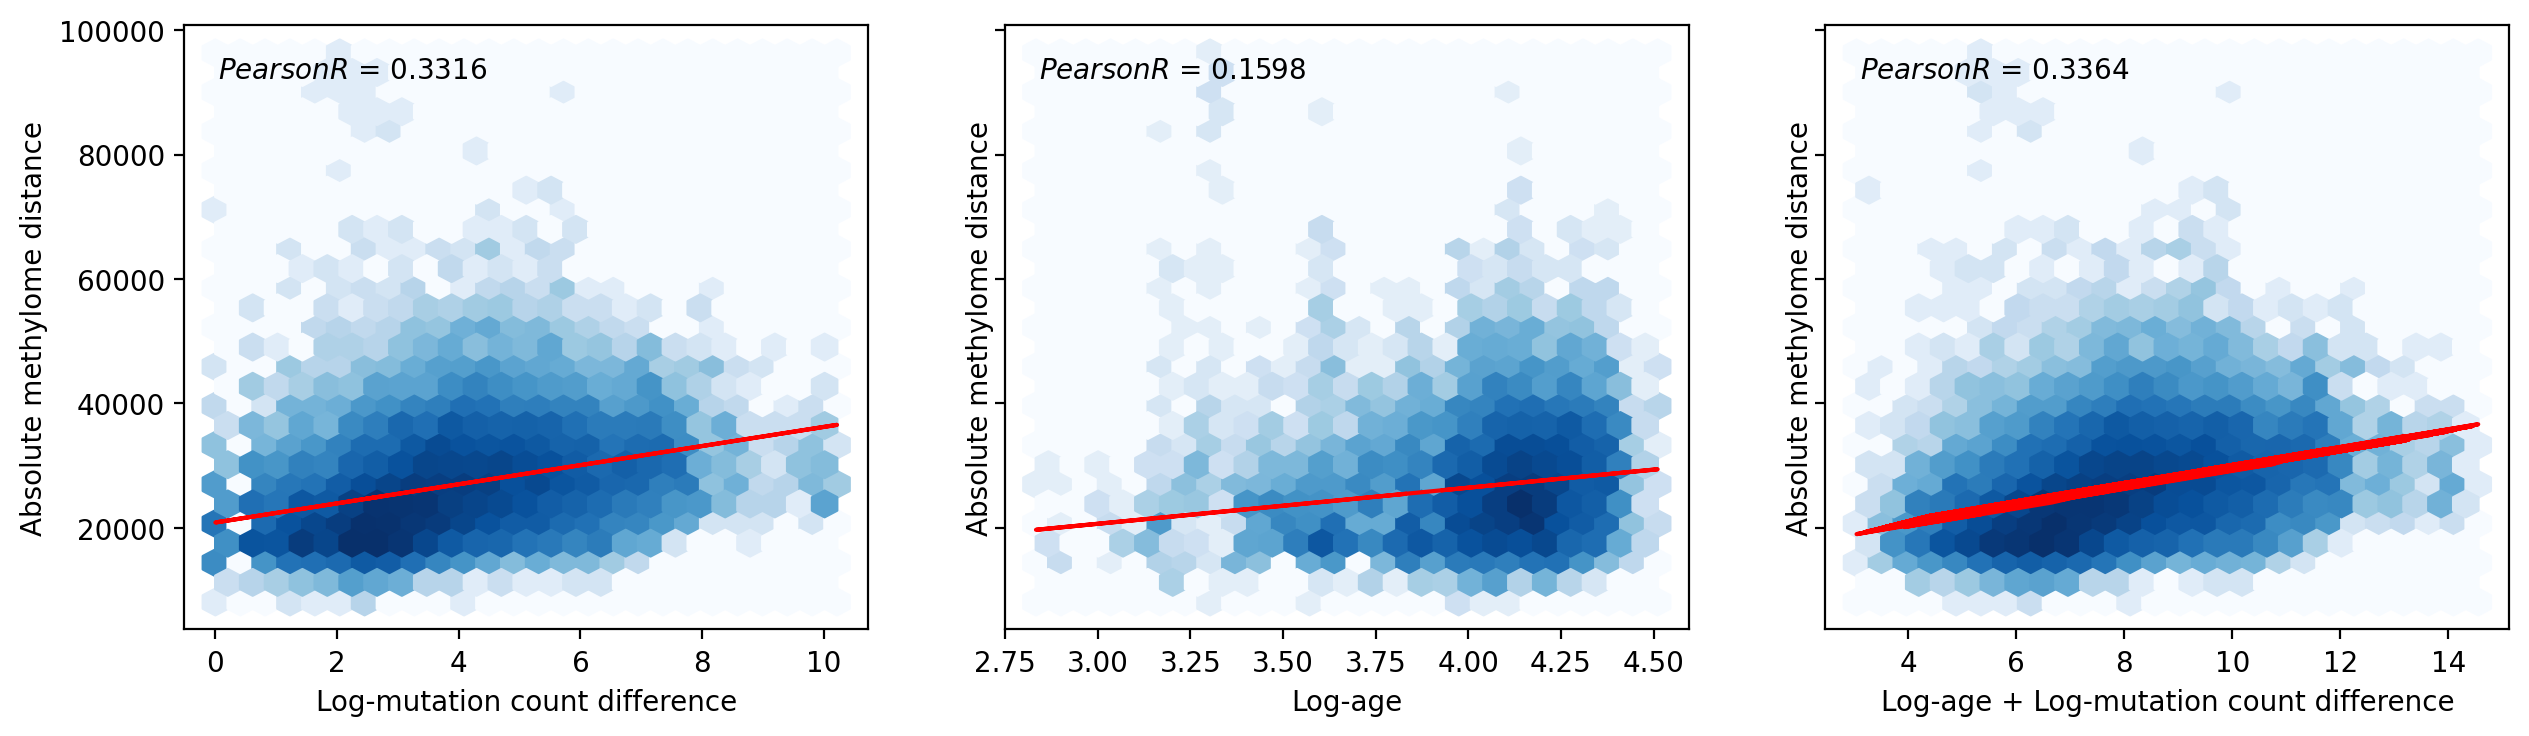

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15, 4), sharey=True, dpi=100)

# do linear regression of mut_diff + age on abs_diff_sum
# fit model
pair_comp_df['log_mut_diff'] = np.log(1+pair_comp_df['mut_diff'])
model1 = smf.ols("abs_diff_sum ~ log_mut_diff", pair_comp_df)
result1 = model1.fit()
# print model summary
print(result1.summary())
# get r value
rsq_1 = result1.rsquared
# print summary
# plot a scatter plot of the data and with the regression line
axes[0].hexbin(pair_comp_df['log_mut_diff'], pair_comp_df['abs_diff_sum'], bins='log', cmap='Blues', gridsize=25)
axes[0].plot(pair_comp_df['log_mut_diff'], result1.fittedvalues, color='red')
axes[0].set_xlabel('Log-mutation count difference')
axes[0].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
axes[0].text(0.05, 0.95, '$PearsonR$ = {:.4f}'.format(np.sqrt(rsq_1)), transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
# do linear regression of mut_diff + age on abs_diff_sum
# fit model
pair_comp_df['log_age'] = np.log(1+pair_comp_df['age'])
model2 = smf.ols("abs_diff_sum ~ log_age", pair_comp_df)
result2 = model2.fit()
# get r value
rsq_2 = result2.rsquared
# plot a scatter plot of the data and with the regression line
axes[1].hexbin(pair_comp_df['log_age'], pair_comp_df['abs_diff_sum'], bins='log', cmap='Blues', gridsize=25)
axes[1].plot(pair_comp_df['log_age'], result2.fittedvalues, color='red')
axes[1].set_xlabel('Log-age')
axes[1].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
axes[1].text(0.05, 0.95, '$PearsonR$ = {:.4f}'.format(np.sqrt(rsq_2)), transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
# do linear regression of mut_diff + age on abs_diff_sum
# fit model
model3 = smf.ols("abs_diff_sum ~ log_age + log_mut_diff", pair_comp_df)
result3 = model3.fit()
# get r value
rsq_3 = result3.rsquared
# print summary
# plot a scatter plot of the data and with the regression line
axes[2].hexbin((pair_comp_df['log_age'] + pair_comp_df['log_mut_diff']), pair_comp_df['abs_diff_sum'], bins='log', cmap='Blues', gridsize=25)
axes[2].plot((pair_comp_df['log_age'] + pair_comp_df['log_mut_diff']), 
                result3.params['Intercept'] + (result3.params['log_age'] * pair_comp_df['log_age'])
                + (result3.params['log_mut_diff'] * pair_comp_df['log_mut_diff']), color='red')
axes[2].set_xlabel('Log-age + Log-mutation count difference')
axes[2].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
axes[2].text(0.05, 0.95, '$PearsonR$ = {:.4f}'.format(np.sqrt(rsq_3)), transform=axes[2].transAxes, fontsize=10, verticalalignment='top')

#### Different ages

In [96]:
pair_comp_diffAges_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_101322", "pair_comp_500_diffAges.parquet"))
pair_comp_corr_diffAges_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_101322", "pair_comp_corr_spearman_500_diffAges.parquet"))

In [97]:
pair_comp_corr_diffAges_df.columns = ['Absolute methylome\ndistance', 'Negative methylomes\ndistance', 'Positive methylomes\ndistance', 'Age sample 2', 'Mutation count\ndifference', 'C>T mutation count\ndifference', 'Age sample 1', 'Age difference']
pair_comp_corr_diffAges_df.index =  ['Absolute methylome\ndistance', 'Negative methylomes\ndistance', 'Positive methylomes\ndistance', 'Age sample 2', 'Mutation count\ndifference', 'C>T mutation count\ndifference', 'Age sample 1', 'Age difference']
#pair_comp_corr_df = pair_comp_corr_df.iloc[[0, 5, 3, 4], [0, 5, 3, 4]]

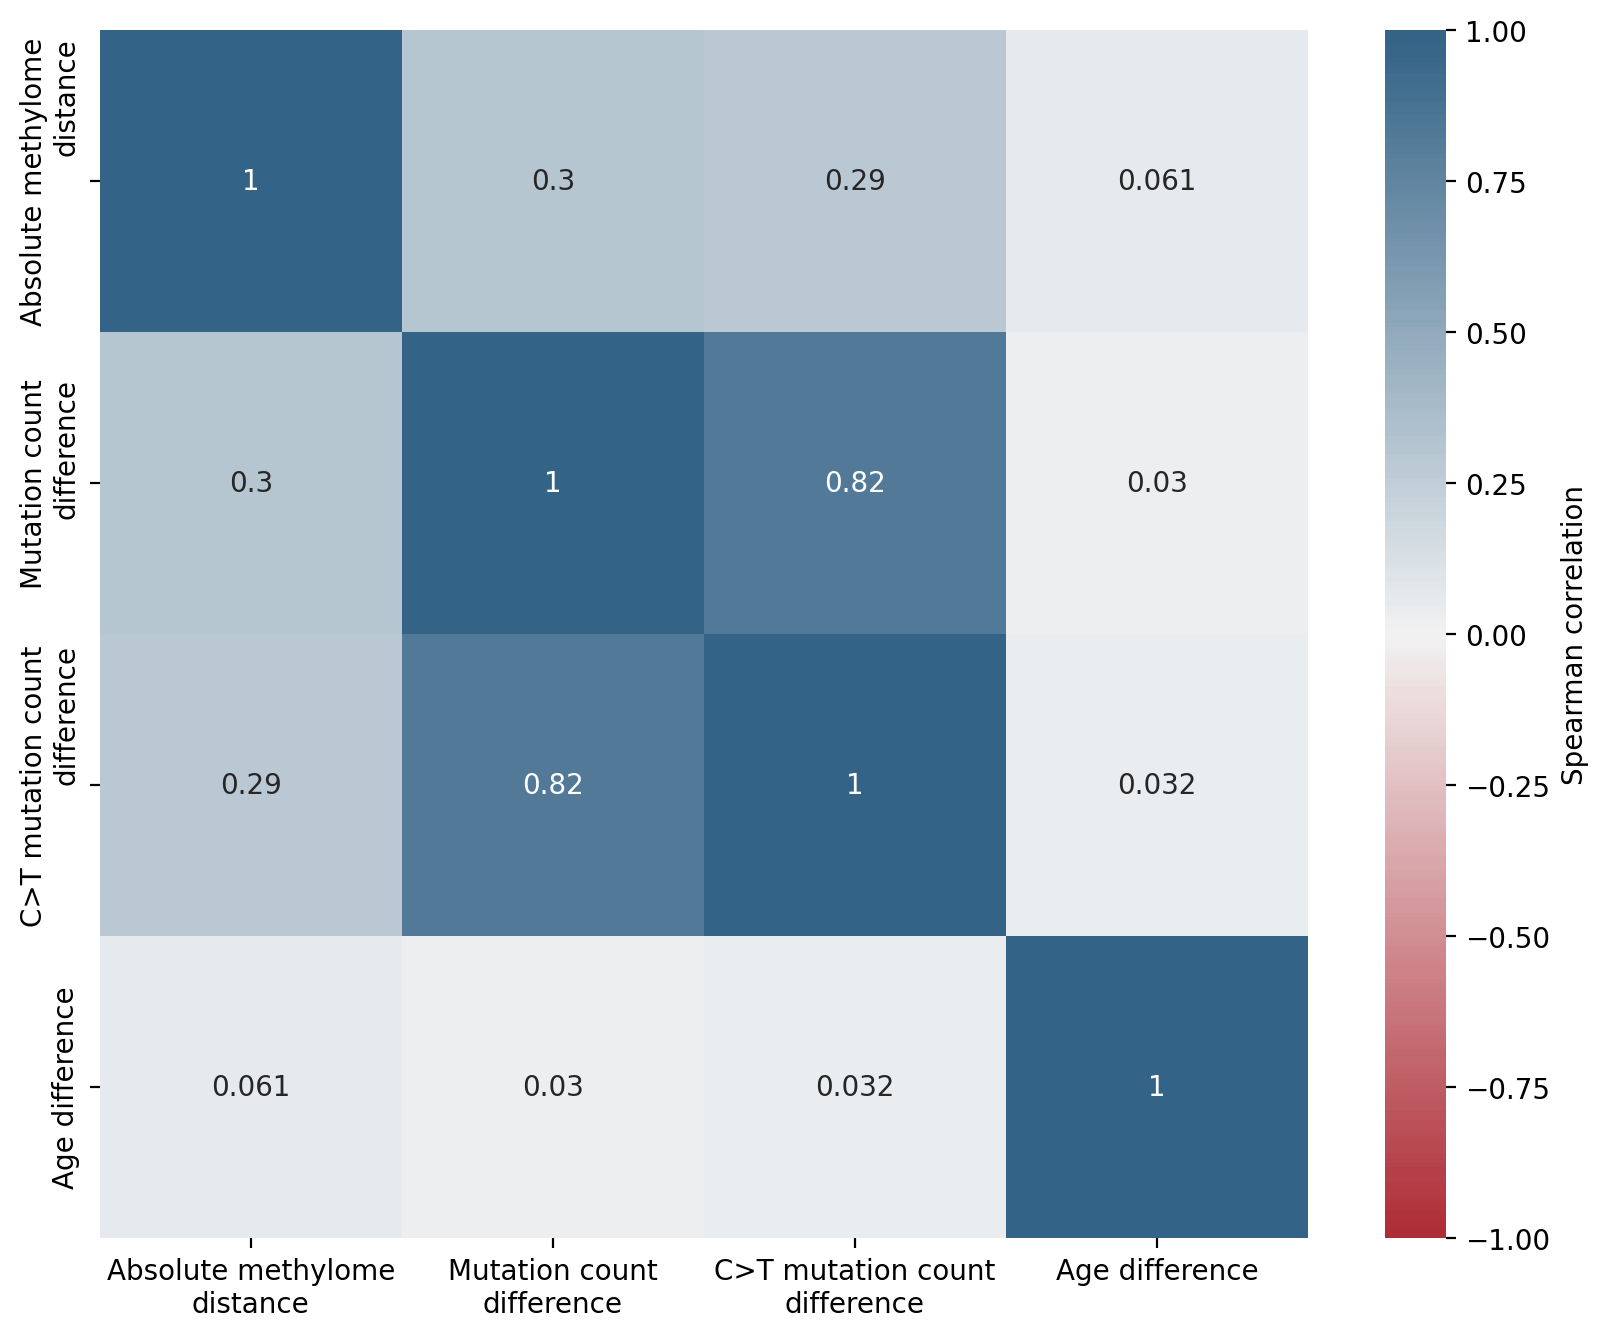

In [98]:
fig, axes = plt.subplots(figsize=(10, 8), dpi=100)
ax = sns.heatmap(
    pair_comp_corr_diffAges_df.iloc[[0,4, 5,7 ], [0,4, 5,7 ]], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 240, l=40, n=200),
    square=True, ax=axes, annot=True, cbar=True
)
# name color bar
# make color bar same height as plot
ax.collections[0].colorbar.set_label("Spearman correlation")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='center'
);
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=90,
    verticalalignment='center'
);

0.0027989766416816053


Text(0.05, 0.95, '$Spearman\\ \\rho$ = 0.2883')

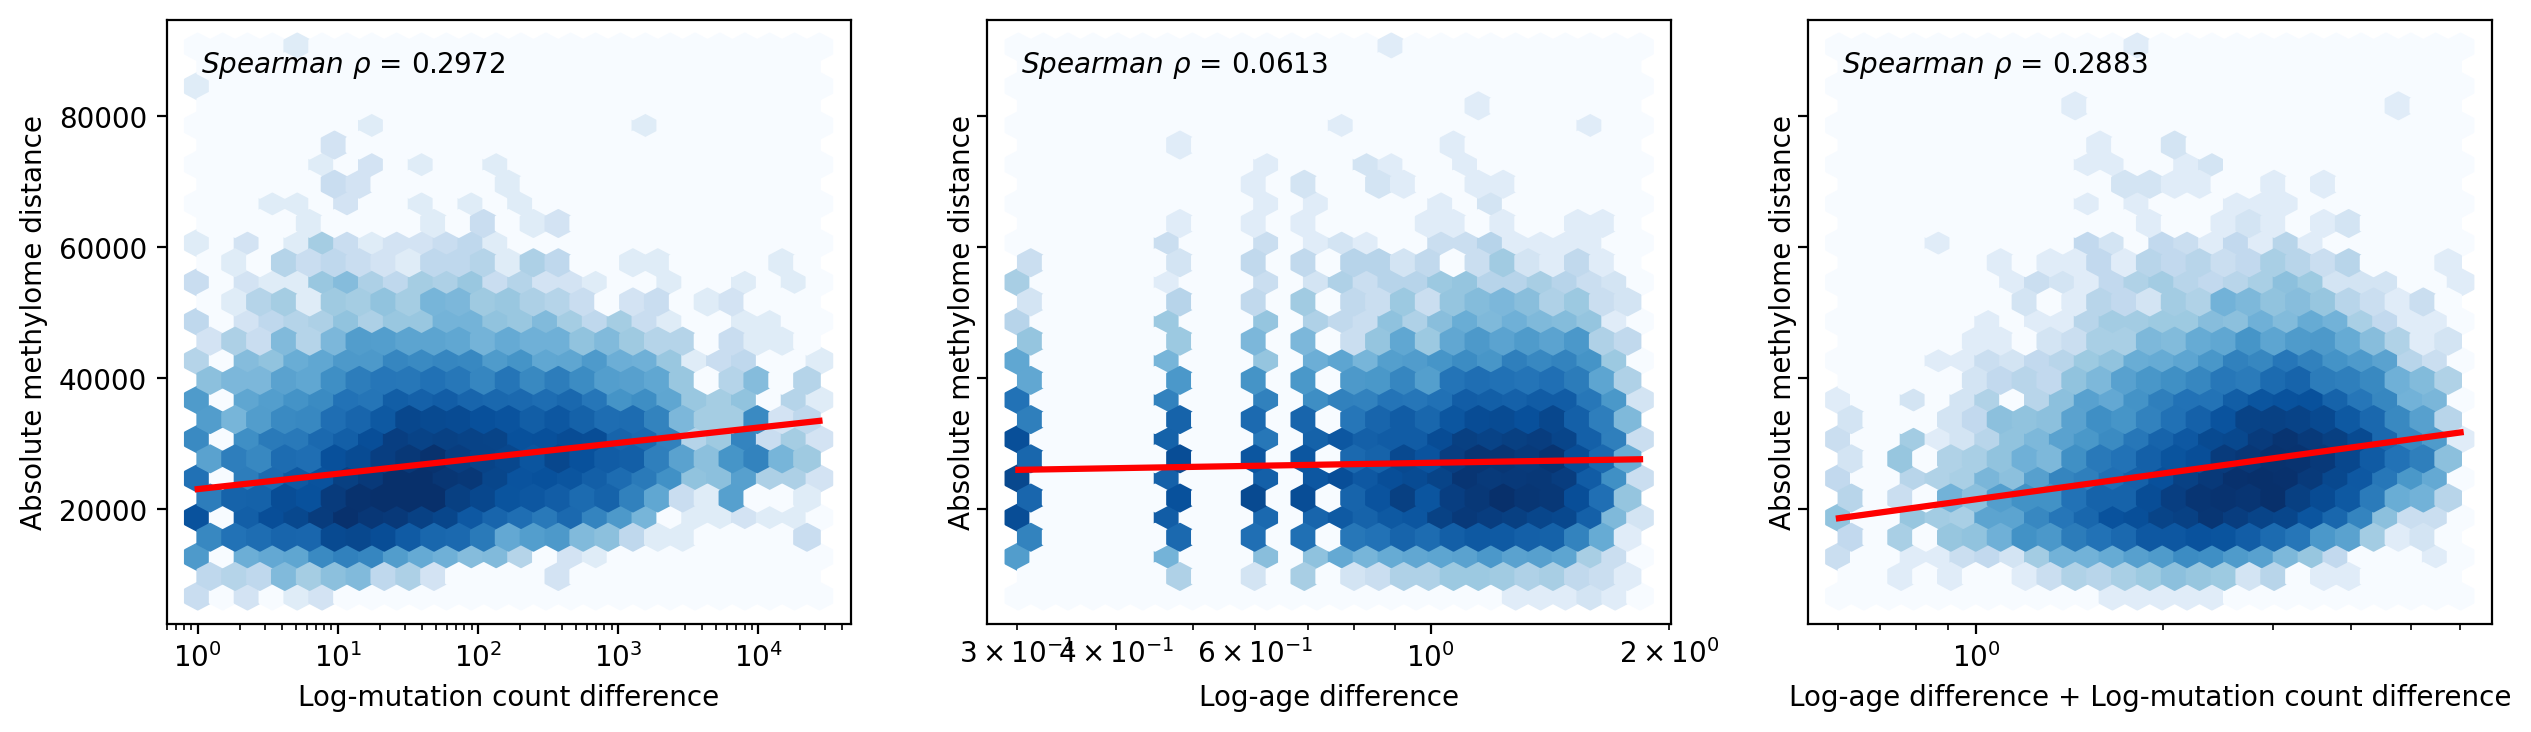

In [109]:
fig, axes = plt.subplots(1,3, figsize=(15, 4), sharey=True, dpi=100, gridspec_kw={'width_ratios': [1, 1, 1]})

pair_comp_diffAges_df['log_mut_diff'] = np.log10(1+pair_comp_diffAges_df['mut_diff'])
pair_comp_diffAges_df['log_age_diff'] = np.log10(1+pair_comp_diffAges_df['age_diff'])

"""pair_comp_diffAges_df['log_mut_diff'] = pair_comp_diffAges_df['mut_diff']
pair_comp_diffAges_df['log_age_diff'] = pair_comp_diffAges_df['age_diff']"""

# drop rows where log_mut_diff or log_age_diff is <= 0
pair_comp_diffAges_df = pair_comp_diffAges_df[(pair_comp_diffAges_df['log_mut_diff'] > 0) & (pair_comp_diffAges_df['log_age_diff'] > 0)]

#################

model1 = smf.ols("abs_diff_sum ~ log_mut_diff", pair_comp_diffAges_df)
result1 = model1.fit()
# get r value
rsq_1 = result1.rsquared
# plot a scatter plot of the data and with the regression line
axes[0].hexbin(pair_comp_diffAges_df['mut_diff'], pair_comp_diffAges_df['abs_diff_sum'], bins='log', xscale='log', cmap='Blues', gridsize=25)
# make x axis ticks and tick labels log scale in scientific notation
#axes[0].plot(pair_comp_diffAges_df['log_mut_diff'], result1.fittedvalues, color='red')
sns.regplot(x=pair_comp_diffAges_df['mut_diff'], y=pair_comp_diffAges_df['abs_diff_sum'], logx=True, ax=axes[0], scatter=False, color='red')

axes[0].set_xlabel('Log-mutation count difference')
axes[0].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
#axes[0].text(0.05, 0.95, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_1)), transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
# spearman correlation
axes[0].text(0.05, 0.95, r'$Spearman\ \rho$ = {:.4f}'.format(pair_comp_corr_diffAges_df.loc['Mutation count\ndifference', 'Absolute methylome\ndistance']), transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

#################

model2 = smf.ols("abs_diff_sum ~ log_age_diff", pair_comp_diffAges_df)
result2 = model2.fit()
# get r value
rsq_2 = result2.rsquared
print(rsq_2)
# plot a scatter plot of the data and with the regression line
axes[1].hexbin(pair_comp_diffAges_df['log_age_diff'], pair_comp_diffAges_df['abs_diff_sum'], bins='log', xscale='log', cmap='Blues', gridsize=25)
# sns regplot
sns.regplot(x=pair_comp_diffAges_df['log_age_diff'], y=pair_comp_diffAges_df['abs_diff_sum'], ax=axes[1], logx=True, scatter=False, color='red')
axes[1].set_xlabel('Log-age difference')
axes[1].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
#axes[1].text(0.05, 0.95, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_2)), transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
# spearman correlation
axes[1].text(0.05, 0.95, r'$Spearman\ \rho$ = {:.4f}'.format(pair_comp_corr_diffAges_df.loc['Age difference', 'Absolute methylome\ndistance']), transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

##################

model3 = smf.ols("abs_diff_sum ~ log_age_diff + log_mut_diff", pair_comp_diffAges_df)
result3 = model3.fit()
# get r value
rsq_3 = result3.rsquared
# print summary
# plot a scatter plot of the data and with the regression line
axes[2].hexbin((pair_comp_diffAges_df['log_age_diff'] + pair_comp_diffAges_df['log_mut_diff']), pair_comp_diffAges_df['abs_diff_sum'],xscale='log', bins='log', cmap='Blues', gridsize=25)
# sns regplot
sns.regplot(data=pair_comp_diffAges_df, x=(pair_comp_diffAges_df['log_age_diff'] + pair_comp_diffAges_df['log_mut_diff']), y=pair_comp_diffAges_df['abs_diff_sum'], logx=True, ax=axes[2], scatter=False, color='red')
"""axes[2].plot((pair_comp_diffAges_df['log_age_diff'] + pair_comp_diffAges_df['log_mut_diff']), 
                result3.params['Intercept'] + (result3.params['log_age_diff'] * pair_comp_diffAges_df['log_age_diff'])
                + (result3.params['log_mut_diff'] * pair_comp_diffAges_df['log_mut_diff']), color='red')"""
axes[2].set_xlabel('Log-age difference + Log-mutation count difference')
axes[2].set_ylabel('Absolute methylome distance')
# add r^2 value to plot
#axes[2].text(0.05, 0.95, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_3)), transform=axes[2].transAxes, fontsize=10, verticalalignment='top')
# calculate spearman correlation
rho, pval = spearmanr(pair_comp_diffAges_df['log_age_diff'] + pair_comp_diffAges_df['log_mut_diff'], pair_comp_diffAges_df['abs_diff_sum'])
# spearman correlation
axes[2].text(0.05, 0.95, r'$Spearman\ \rho$ = {:.4f}'.format(rho), transform=axes[2].transAxes, fontsize=10, verticalalignment='top')

Text(0.02, 0.8, '$Spearman\\ \\rho$ = 0.2986')

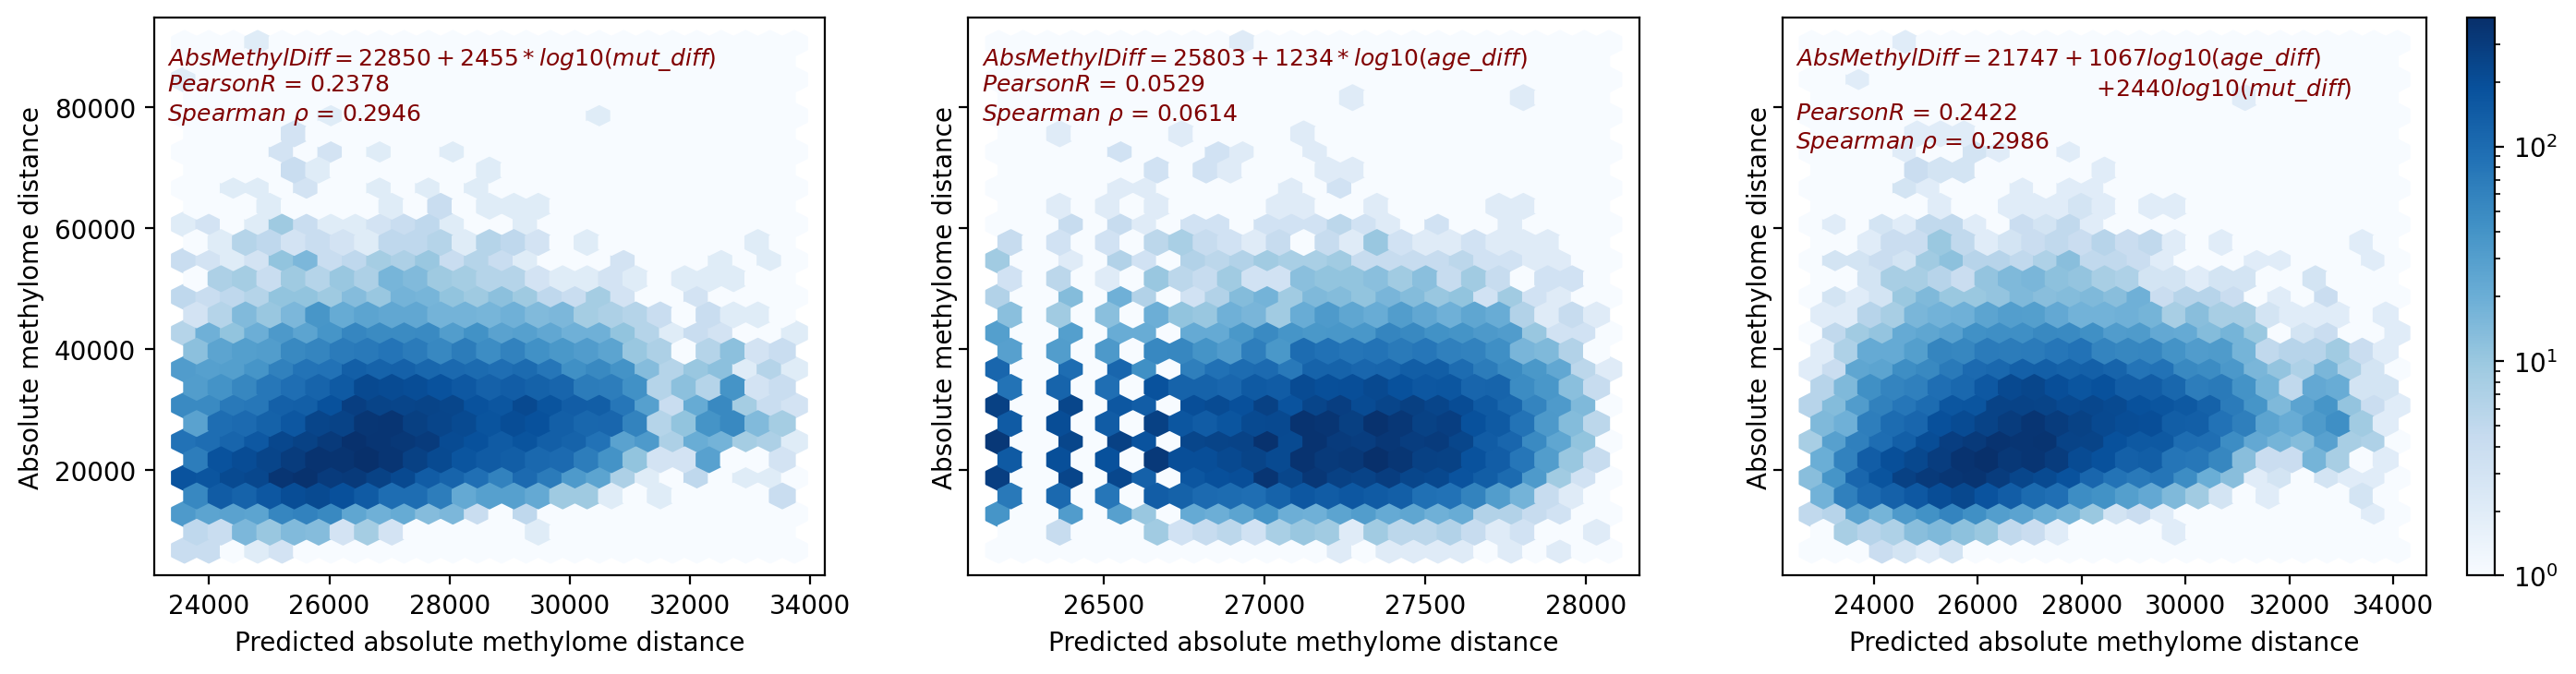

In [124]:
fig, axes = plt.subplots(1,3, figsize=(17, 4), sharey=True, sharex=False, dpi=100, gridspec_kw={'width_ratios': [1, 1, 1.2]})

model1 = smf.ols("abs_diff_sum ~ log_mut_diff", pair_comp_diffAges_df)
result1 = model1.fit()
# get r^2 value
rsq_1 = result1.rsquared
# get predicted values
pred_val = result1.fittedvalues.copy()
cb = axes[0].hexbin( pred_val, pair_comp_diffAges_df['abs_diff_sum'], bins='log', cmap='Blues', gridsize=25)
# set labels
axes[0].set_ylabel('Absolute methylome distance')
axes[0].set_xlabel('Predicted absolute methylome distance')
# add r^2 value to plot
axes[0].text(0.02, 0.90, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_1)), transform=axes[0].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add linear regression equation to plot
axes[0].text(0.02, 0.95, '$AbsMethylDiff = {:.0f} + {:.0f}*log10(mut\_diff)$'.format(result1.params['Intercept'], result1.params['log_mut_diff']), transform=axes[0].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add line actual value vs predicted value based on result1
axes[0].plot()
# add spearman rho
rho, pval = spearmanr(pred_val, pair_comp_diffAges_df['abs_diff_sum'])
axes[0].text(0.02, 0.85, r'$Spearman\ \rho$ = {:.4f}'.format(rho), transform=axes[0].transAxes, fontsize=9, verticalalignment='top', color='maroon')
##########

model2 = smf.ols("abs_diff_sum ~ log_age_diff", pair_comp_diffAges_df)
result2 = model2.fit()
# get r^2 value
rsq_2 = result2.rsquared
# get predicted values
pred_val = result2.fittedvalues.copy()
cb = axes[1].hexbin(pred_val, pair_comp_diffAges_df['abs_diff_sum'],  bins='log', cmap='Blues', gridsize=25)
# set labels
axes[1].set_ylabel('Absolute methylome distance')
axes[1].set_xlabel('Predicted absolute methylome distance')
# add r^2 value to plot
axes[1].text(0.02, 0.90, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_2)), transform=axes[1].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add linear regression equation to plot
axes[1].text(0.02, 0.95, '$AbsMethylDiff = {:.0f} + {:.0f}*log10(age\_diff)$'.format(result2.params['Intercept'], result2.params['log_age_diff']), transform=axes[1].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add spearman rho
rho, pval = spearmanr(pred_val, pair_comp_diffAges_df['abs_diff_sum'])
axes[1].text(0.02, 0.85, r'$Spearman\ \rho$ = {:.4f}'.format(rho), transform=axes[1].transAxes, fontsize=9, verticalalignment='top', color='maroon')

#########

model3 = smf.ols("abs_diff_sum ~ log_age_diff + log_mut_diff", pair_comp_diffAges_df)
result3 = model3.fit()
# get r^2 value
rsq_3 = result3.rsquared
# get predicted values
pred_val = result3.fittedvalues.copy()
cb = axes[2].hexbin(pred_val, pair_comp_diffAges_df['abs_diff_sum'], bins='log', cmap='Blues', gridsize=25)
# add color bar
fig.colorbar(cb, ax=axes[2])
# add label to color bar
cb.set_label('Count of samples')
# set labels
axes[2].set_ylabel('Absolute methylome distance')
axes[2].set_xlabel('Predicted absolute methylome distance')
# add r^2 value to plot
axes[2].text(0.02, 0.85, '$Pearson R$ = {:.4f}'.format(np.sqrt(rsq_3)), transform=axes[2].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add linear regression equation to plot
axes[2].text(0.02, 0.95, '$AbsMethylDiff = {:.0f} + {:.0f}log10(age\_diff)$ \n\t\t\t\t\t $+ {:.0f}log10(mut\_diff)$'.format(result3.params['Intercept'], result3.params['log_age_diff'], result3.params['log_mut_diff']), transform=axes[2].transAxes, fontsize=9, verticalalignment='top', color='maroon')
# add spearman rho
rho, pval = spearmanr( pred_val, pair_comp_diffAges_df['abs_diff_sum'])
axes[2].text(0.02, 0.80, r'$Spearman\ \rho$ = {:.4f}'.format(rho), transform=axes[2].transAxes, fontsize=9, verticalalignment='top', color='maroon')

## PCA on methylome

In [ ]:
pca, methyl_chr1_tranf, pc_corrs_w_mut_counts = utils.methylome_pca(all_methyl_df_t, illumina_cpg_locs_df, all_mut_df, num_pcs=40)

In [ ]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')

## Miscellaneous code to save

### Get all correlations chrom 1

In [ ]:
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]

In [ ]:
chrom_one_corr = chr_methyl_df.T.corr()
chrom_one_corr.to_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1_PANCAN.parquet"))

In [ ]:
# read back in 
chrom_one_corr = pd.read_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))

### EWAS chr1

In [ ]:
# only keep sites on chr 1
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]
# only keep ages that match to columns of chr_methyl_df
meta_df = all_meta_df.loc[all_meta_df.index.isin(chr_methyl_df.columns)]
# only keep columns that have ages
chr_methyl_df = chr_methyl_df[chr_methyl_df.columns[chr_methyl_df.columns.isin(meta_df.index)]]
# put samples in same order as methylation
meta_df = meta_df.loc[chr_methyl_df.columns]

In [ ]:
# do EWAS calculation
ewas_df = utils.EWAS(X = chr_methyl_df, y = meta_df['age_at_index'], out_fn = os.path.join(dependency_f_dir, "all_chr1_EWAS_results_PANCAN.parquet"))
#ewas_df.index = chr_methyl_df.index

In [ ]:
# read in if already calculated
ewas_df = pd.read_parquet(os.path.join(dependency_f_dir, "all_chr1_EWAS_results_PANCAN.parquet"))
ewas_df.index = chr_methyl_df.index

In [ ]:
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')

## Distance-MF correlation plots

In [ ]:
fig, axes = plt.subplots()
this_dist_corr_df = dist_corr_df
this_dist_corr_df['distance'] = np.log(this_dist_corr_df['distance'])
bin_edges = []
for i in range(6):
    step = (dist_corr_df['distance'].max() - dist_corr_df['distance'].min())/5
    bin_edges.append(dist_corr_df['distance'].min() + (step * i))
print(bin_edges)

boxes = [dist_corr_df[(dist_corr_df['distance'] < bin_edges[i+1] ) & (dist_corr_df['distance'] >= bin_edges[i])]['corr'] for i in range(len(bin_edges)-1)]


bp = axes.boxplot(boxes, flierprops=dict(markersize=.1), showfliers=False, labels=["{} - {}".format(round(bin_edges[i],1), round(bin_edges[i+1],1) ) for i in range(len(bin_edges)-1)], patch_artist=True, boxprops=dict(facecolor="maroon", alpha=0.7, ))
# change color of median
for median in bp['medians']: 
    median.set(color ='black', 
               linewidth = 1)
axes.set_xlabel("log-distance bp")
axes.set_ylabel("CpG pair Pearson r")

dist_corr_df['distance'] = np.exp(dist_corr_df['distance'])

### All CpGs chr1

In [ ]:
# get CpGs both measures have
common_cpgs = list(set(chrom_one_distances.columns) & set(chrom_one_corr.columns))
# select 5000 of these CpGs at random
# put both datframes in this order
dist_tp = chrom_one_distances.loc[common_cpgs, common_cpgs]
corr_tp = chrom_one_corr.loc[common_cpgs, common_cpgs]
# rename index because right now both are named same thing and this causes error with stacking
corr_tp.index.rename("other_cpgs", inplace=True)# 

In [ ]:
len(common_cpgs)

In [ ]:
# convert to long dfs
corr_tp_s = corr_tp.stack().reset_index()
corr_tp_s.columns = ['cpg1','cpg2','corr']
dist_tp_s = dist_tp.stack().reset_index()
dist_tp_s.columns = ['cpg1','cpg2','distance']


In [ ]:
# drop rows of df with same CpG in both columns
dist_tp_s = dist_tp_s.loc[dist_tp['distance'] != 0]
corr_tp_s = corr_tp_s.loc[corr_tp['cpg1'] != corr_tp['cpg2']]

In [ ]:
mean_methyl_df = all_methyl_df_t.mean(axis=0)

In [ ]:
dist_tp

In [ ]:
fig, axes = plt.subplots(figsize=(6,4), dpi=175)
p = axes.hexbin(dist_tp['distance'].iloc[:7023295], np.abs(corr_tp['corr'].iloc[:7023295]), bins='log', xscale='log', cmap="Reds", gridsize=40)
fig.colorbar(p)
sns.regplot(x=dist_tp['distance'].iloc[:7023295], y=np.abs(corr_tp['corr'].iloc[:7023295]), logx=True, ax=axes, scatter=False, color='black')
axes.set_xlabel("Distance between CpG sites (bp)")
axes.set_ylabel("MF Pearson correlation")


In [ ]:
corr_dist_df = pd.DataFrame({'corrs':np.abs(corr_tp_s['corr']), 'dists':dist_tp_s['distance']})
utils.plot_corr_dist_boxplots(corr_dist_df)

In [ ]:
# distance range on x axis, corr hist on y

In [ ]:
spearmanr(np.log(dist_tp['distance']), np.abs(corr_tp['corr']))

### selecting highest correlated CpGs

In [ ]:
# get CpGs both measures have
common_cpgs = list(set(chrom_one_distances.columns) & set(chrom_one_corr.columns))
# select 5000 of these CpGs at random
# put both datframes in this order
dist_df = chrom_one_distances.loc[common_cpgs, common_cpgs]
corr_df = chrom_one_corr.loc[common_cpgs, common_cpgs]

In [ ]:
# for a given cpg, get counts of distance of top N correlated sites
def get_corr_by_distance(corr_df, dist_df):
    all_corrs = []
    all_dists = []
    for cpg_name in corr_df:
        high_corrs = corr_df[cpg_name].nlargest(11)
        # remove self
        high_corrs = high_corrs.iloc[1:]
        corrs = high_corrs.to_list()
        dists = dist_df.loc[cpg_name, high_corrs.index.to_list()].to_list()
        all_corrs+=corrs
        all_dists+=dists
    
    return pd.DataFrame({'corrs': all_corrs, 'dists':all_dists})

In [ ]:
corr_dist_df = get_corr_by_distance(corr_df, dist_df)

In [ ]:
corr_dist_df.shape

In [ ]:
fig, axes = plt.subplots(figsize=(8,6))
p = axes.hexbin(corr_dist_df['dists'], corr_dist_df['corrs'], bins='log', xscale='log', cmap="Reds", gridsize=40)
fig.colorbar(p)
sns.regplot(x=corr_dist_df['dists'], y=corr_dist_df['corrs'], logx=True, ax=axes, scatter=False, color='black')
axes.set_xlabel("Distance between CpG sites (bp)")
axes.set_ylabel("MF Pearson correlation")


In [ ]:
utils.plot_corr_dist_boxplots(corr_dist_df)

In [ ]:
spearmanr(np.log10(corr_dist_df['dists']), corr_dist_df['corrs'])

### plot of CpGs average correlation with top site, second to top, ..., least correlation

#### To help choose # linked sites

In [ ]:
def get_avg_corr(corr_df, dist_df):
    all_corrs = []
    all_dists = []
    for cpg_name in corr_df:
        high_corrs = np.abs(corr_df[cpg_name]).nlargest(1002)
        # remove self
        high_corrs = high_corrs.iloc[1:]
        corrs = high_corrs.to_list()
        all_corrs.append(corrs)
        # also get distances
        dists = dist_df.loc[high_corrs.index, cpg_name]
        all_dists.append(dists.to_list())
    return pd.DataFrame(all_corrs), pd.DataFrame(all_dists)

In [ ]:
top_corrs, top_dists = get_avg_corr(corr_df, dist_df)

In [ ]:
corr_means = np.abs(top_corrs).median()
dist_means = top_dists.median() /1000000

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].scatter(np.arange(0,1000,1), corr_means.to_list(), s=2, color='steelblue')
axes[0].set_xlabel("Correlated sites")
axes[0].set_ylabel("Median correlation")

axes[1].scatter(np.arange(0,1000,1), dist_means,s =2, color='steelblue')
axes[1].set_xlabel("Correlated sites")
axes[1].set_ylabel("Median Distance (Mbp)")
# all sites on chromosome 1, find the 1000 cpg sites with highest correlation
# plot the average correlation and distance for each of these 1000 sites

In [ ]:
from matplotlib import ticker as mticker

fig, axes = plt.subplots(2,1, figsize=(12,9), dpi=100)
sns.violinplot(data=top_corrs.iloc[:,[0,10,100,1000]], ax=axes[0], palette="Blues" )
sns.violinplot(data=np.log10(top_dists.iloc[:,[0,10,100,1000]]), ax=axes[1], palette="Blues")
axes[0].set_ylabel("Pearson r of methylation fraction")
axes[0].set_xlabel("CpG sites sorted by methylation fraction correlation")

axes[1].set_ylabel("Distance between sites (bp)")
axes[1].set_xlabel("CpG sites sorted by methylation fraction correlation")


zzz= axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = axes[1].get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
z= axes[1].yaxis.set_ticks(tick_range)
zz= axes[1].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)


In [ ]:
# get CpGs both measures have
common_cpgs = list(set(chrom_one_distances.columns) & set(chrom_one_corr.columns))
# select 5000 of these CpGs at random
# put both datframes in this order
dist_tp = chrom_one_distances.loc[common_cpgs, common_cpgs]
corr_tp = chrom_one_corr.loc[common_cpgs, common_cpgs]
# rename index because right now both are named same thing and this causes error with stacking
corr_tp.index.rename("other_cpgs", inplace=True)# 